In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pymongo
import pandas as pd

from numpy.polynomial.polynomial import polyfit

from constants import *

In [2]:
client = pymongo.MongoClient('localhost', 27017)
db = client.mineral_db

In [3]:
minerals_in_pgm = {}

for x in db.mineral_coll.find():
    mineral = x['mineral_name']
    
    try:
        pgms = x['pgm']
    except:
        continue
        
    for pgm in pgms:
        if pgm in minerals_in_pgm.keys():
            minerals_in_pgm[pgm].append(mineral)
        else:
            minerals_in_pgm[pgm] = [ mineral ]

In [4]:
pgm_attrs = pd.read_csv('data/2022_pgm_attributes.csv',
                        index_col='MODE'
                       ).transpose()
pgm_attrs.columns = [ s.lower() for s in pgm_attrs.columns ]

def get_attr(p, prop):
    if p[:-1] == 'p45':
        p = 'p45'
        
    if p[:-1] == 'p47':
        p = 'p47'
        
    return pgm_attrs[p][prop]


T_MIN = 'Temp (min) K'
T_MAX = 'Temp (max) K'
T_AVG = 'Temp (average) K'

P_MIN = 'P (min) log Pa'
P_MAX = 'P (max) log Pa'
P_AVG = 'P (average log Pa)'

In [5]:
# pg = point group
pg_db = pd.read_csv('data/Grouped.csv',
                     index_col='mineral name',
                     dtype=str,
                     na_filter=False
                   ).transpose()

In [6]:
symmetry_indices = {
    '1': 1,
    '-1': 2,
    '2': 2,
    'm': 2,
    '2/m': 4,
    '222': 4,
    'mm2': 4,
    '2/m2/m2/m': 8,
    '6': 6,
    '-6': 6,
    '6/m': 12,
    '622': 12,
    '6mm': 12,
    '-6m2': 12,
    '6/m2/m2/m': 24,
    '3': 3,
    '-3': 6,
    '32': 6,
    '3m': 6,
    '-32/m': 12,
    '4': 4,
    '-4': 4,
    '422': 8,
    '4/m': 8,
    '4mm': 8,
    '-42m': 8,
    '4/m2/m2/m': 16,
    '23': 12,
    '2/m-3': 24,
    '432': 24,
    '-43m': 24,
    '4/m32/m': 48,
    # substitutions
    '3mm': 6,  # 3m
    '43m': 24,  # -43m
    '32/m2/m': 12,  # -32/m
    '322': 6,  # 32
    '332/m': 24,  # 2/m-3
    '42m': 8,  # -42m
    '62m': 24,  # 6/m2/m2/m
    '2mm': 8,  # 2/m2/m2/m
    '332': 12,  # 23
    '2/m 2/m 2/m': 8,  # 2/m2/m2/m
    '6/m 2/m 2/m': 24,  # 6/m2/m2/m
    '4/m 2/m 2/m': 16,  # 4/m2/m2/m
    '4/m32/m': 48,  # 4/m-32/m
    '-32m': 12,  # -32/m
    'm-3': 24,  # 2/m-3
    'm-3m': 48,  # 4/m-32/m
    'mm': 4,  # 2/m
}

pgm_symmetry_indices = {}
pgm_populations = {}
n_minerals_in_pgm = {}
no_pg = ''

for p in minerals_in_pgm.keys():
    pgm_pop = { pg: 0 for pg in symmetry_indices.keys() }
    num_minerals = 0
    pgm_sym_ind = 0
    
    for x in db.mineral_coll.find({ 'mineral_name': { '$in': minerals_in_pgm[p] } }):
        mineral = x['mineral_name']
        if mineral not in pg_db.columns:
            no_pg += f'{mineral}: NO PG\n'
            continue
            
        pgs = pg_db[mineral]['point group'].strip().replace('; ', ';').split('; ')
        for pg in pgs:
            if pg in symmetry_indices.keys():
                pgm_pop[pg] += 1
                num_minerals += 1
                pgm_sym_ind += symmetry_indices[pg]
            
    try:
        pgm_symmetry_indices[p] = pgm_sym_ind / max(symmetry_indices.values()) / num_minerals
    except Exception as e:
        print(e)
        
    pgm_populations[p] = pgm_pop
    n_minerals_in_pgm[p] = num_minerals
    
pgm_symmetry_indices = { p: pgm_symmetry_indices[p] for p in sorted(pgm_symmetry_indices) }

with open('no_pg.txt', 'wb') as f:
    f.write(no_pg.encode('utf-8'))

In [7]:
def plot_pgm(ordering, name, n_plots=3, nums=False):
    fig, ax = plt.subplots(n_plots, figsize=(15*3/n_plots, 10*n_plots))
    l = len(ordering)//n_plots
    y_lim_upper = max([ pgm_symmetry_indices[p] for p in ordering ]) * 1.05
    
    if n_plots == 1:
        ax = [ax]
        
    if len(ordering) % n_plots != 0:
        l += 1

    for i in range(n_plots):
        s, e = i*l, (i+1)*l
        num_name = f' ({(i+1)}/{n_plots})' if n_plots > 1 else ''

        r = len(ordering[s:e])
        bars = ax[i].bar(range(r), [ pgm_symmetry_indices[p] for p in ordering[s:e] ])
        ax[i].set_xticks(range(r), labels=ordering[s:e])
        ax[i].tick_params(axis='both', labelsize=FS_TICK)
        ax[i].set_title(f'Symmetry index of different paragenetic modes{num_name}', fontsize=FS_TITLE)
        ax[i].set_ylim(0, y_lim_upper)

    # [ print(f'{p}:\t {sym:.3f}') for p, sym in pgm_symmetry_indices.items() ]

        if nums:
            for n_minerals, bar in zip([ n_minerals_in_pgm[p] for p in ordering[s:e] ], bars):
                ax[i].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                           f'{n_minerals}',
                           ha='center', va='bottom', fontsize=FS_SAMPLE
                          )

    plt.savefig(f'results/{name}.png', dpi=300*3/n_plots)
    
default_ordering = list(pgm_symmetry_indices.keys())[1:]
if not os.path.exists('results'):
    os.mkdir('results')

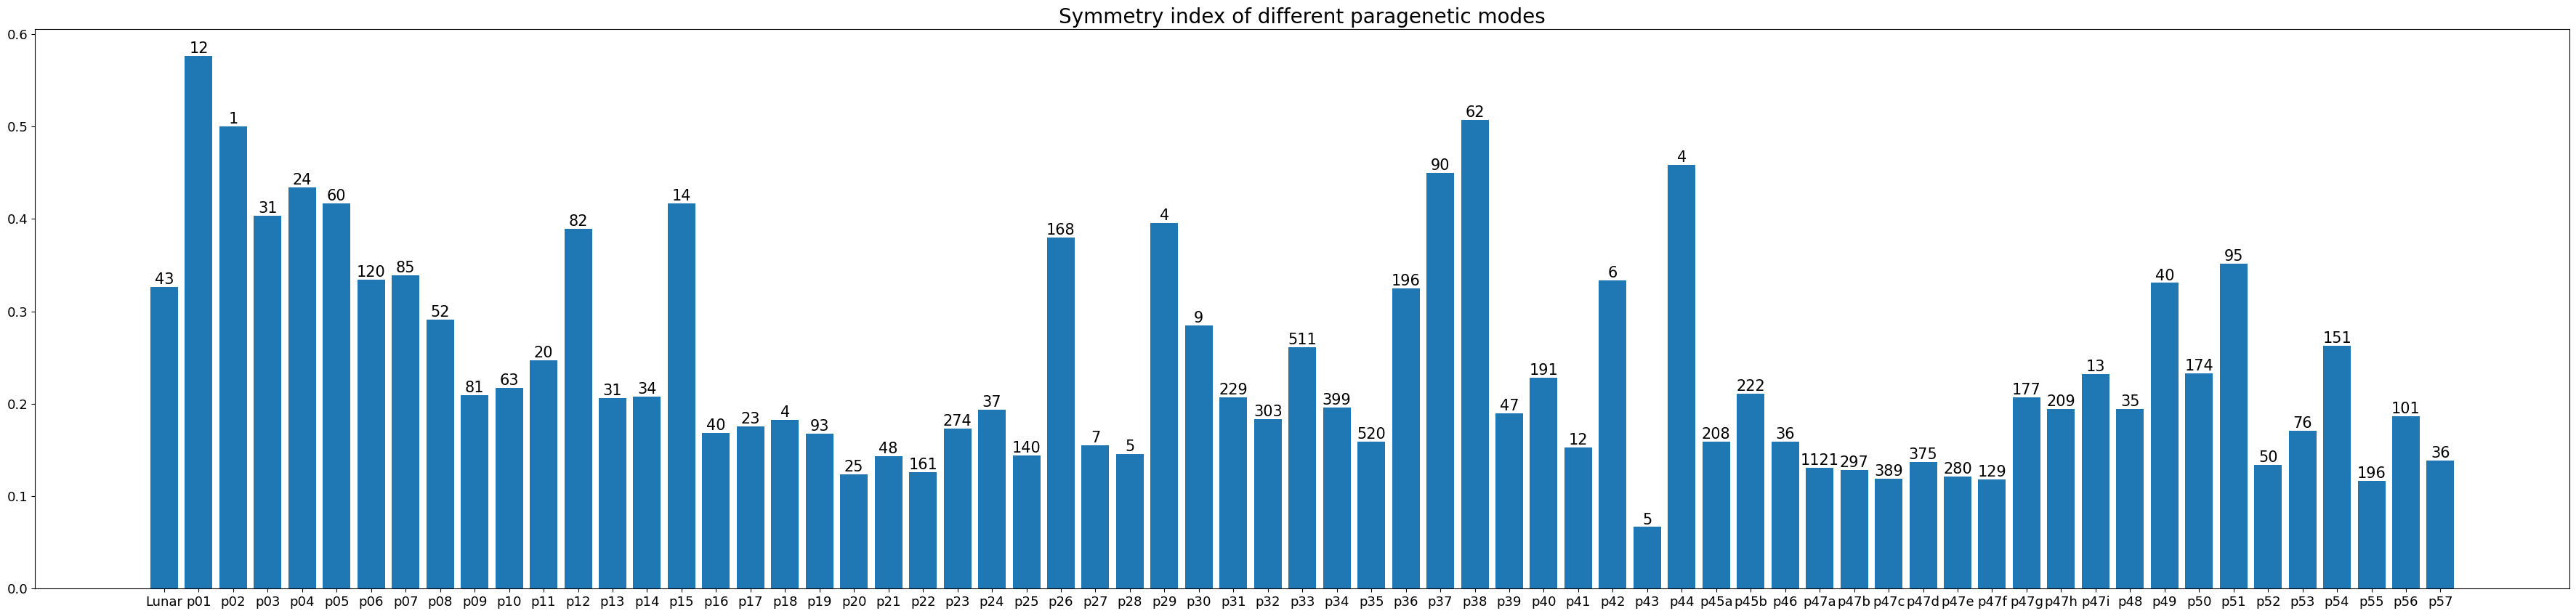

In [8]:
plot_pgm(['Lunar'] + default_ordering, 'graph_pgm_1', n_plots=1, nums=True)

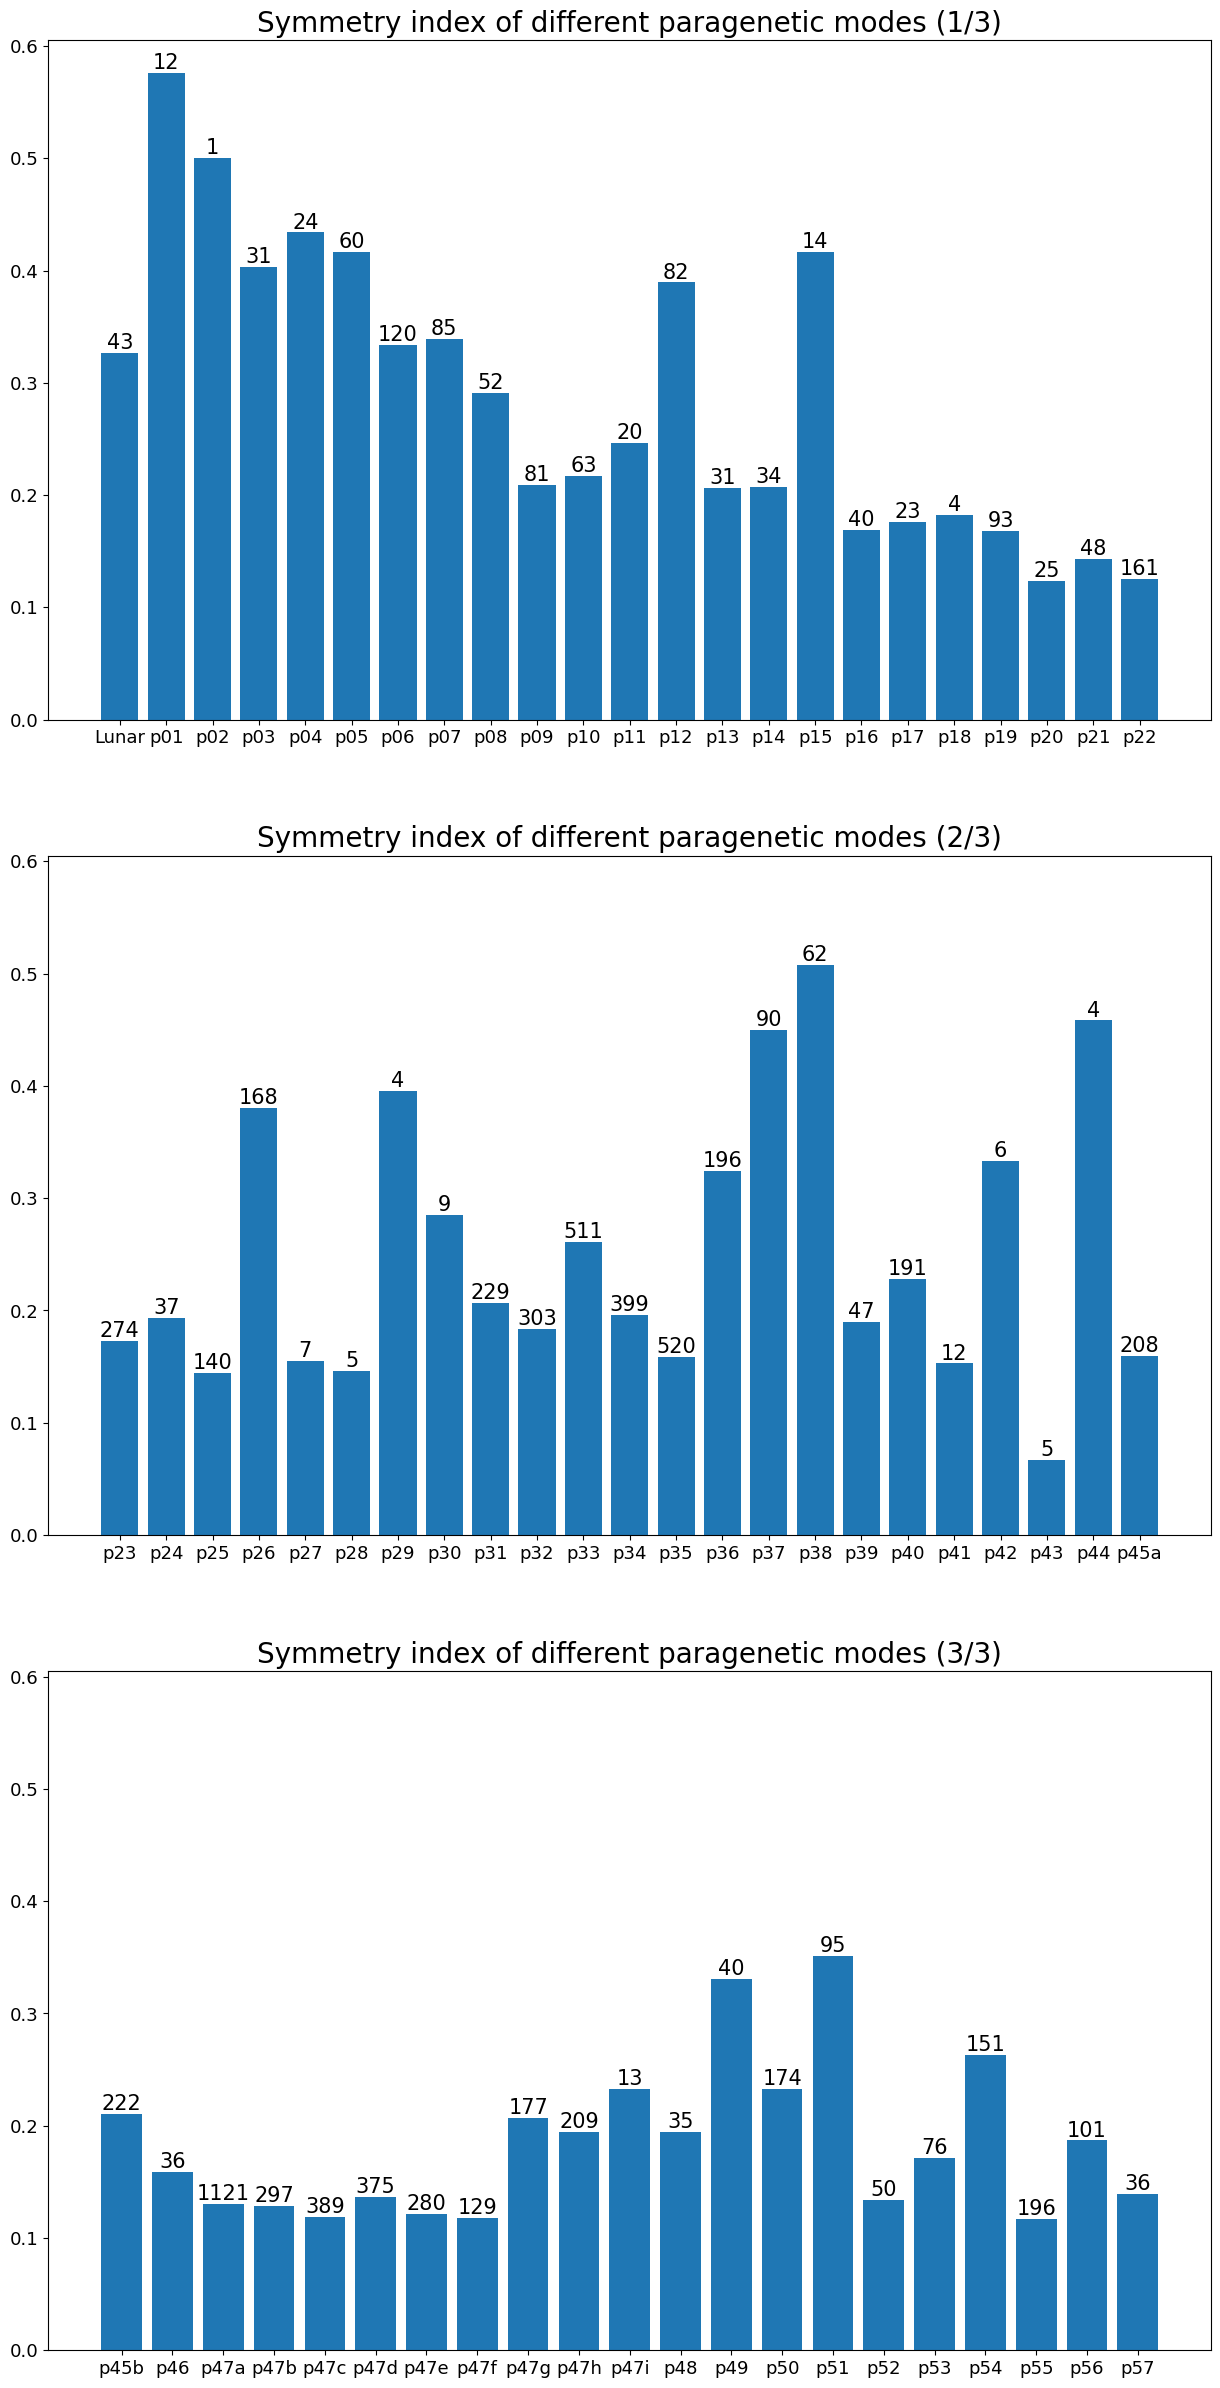

In [9]:
plot_pgm(['Lunar'] + default_ordering, 'graph_pgm', nums=True)

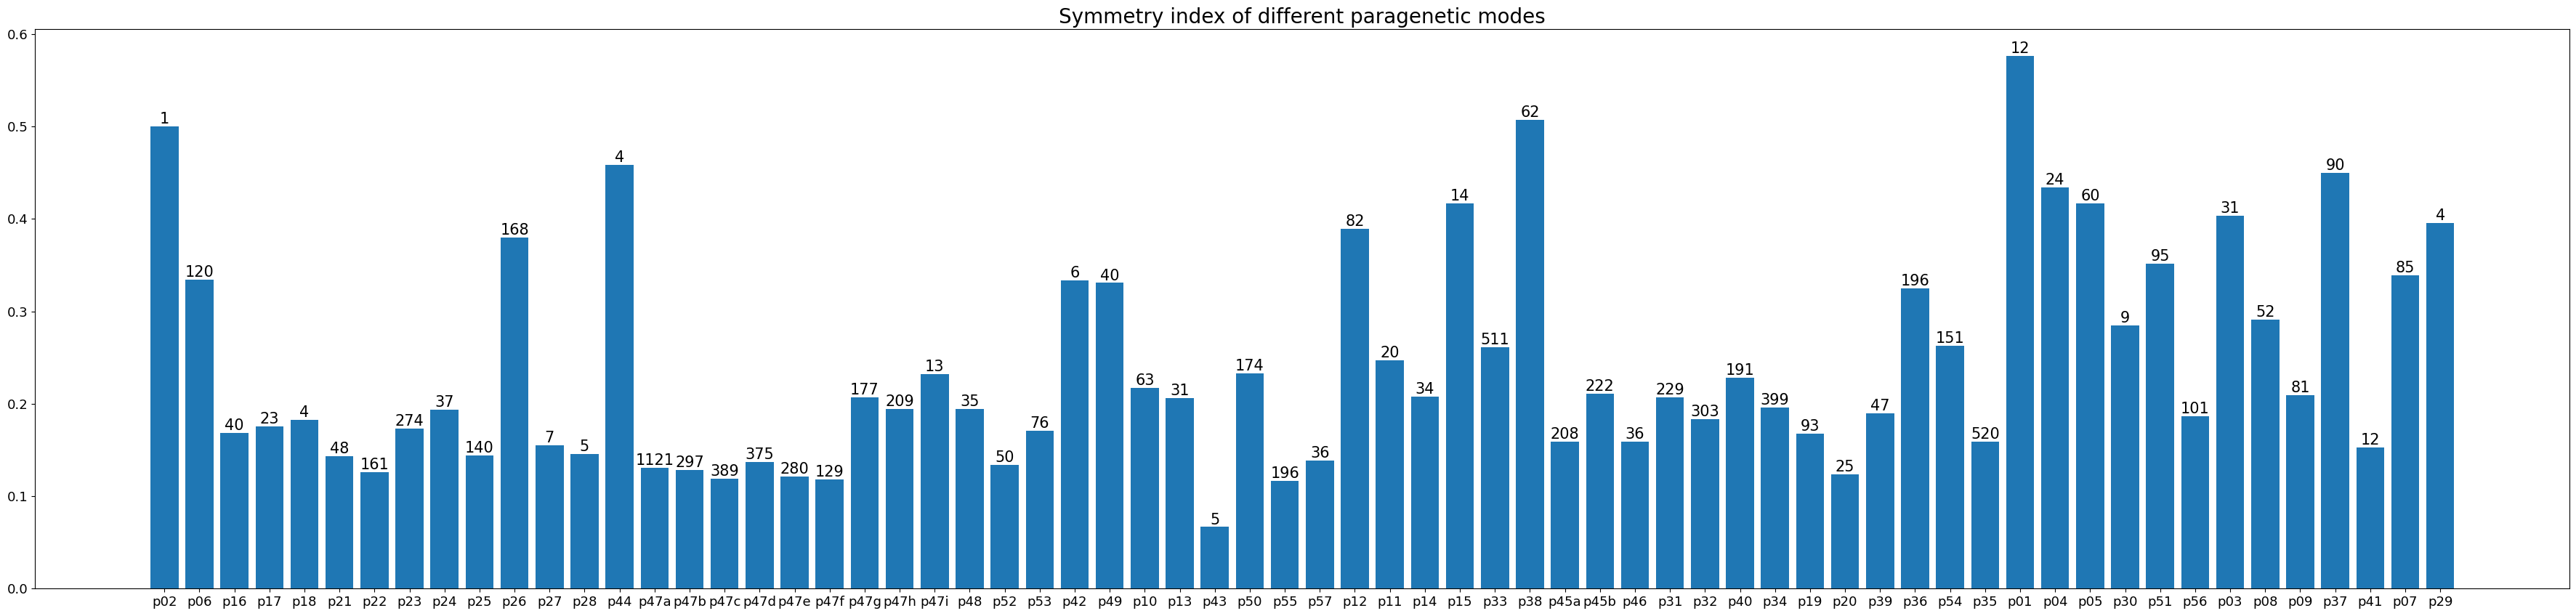

In [10]:
t_min_ordering = sorted(default_ordering, key=lambda p: get_attr(p, T_MIN))
plot_pgm(t_min_ordering, 'graph_pgm_tmin_1', n_plots=1, nums=True)

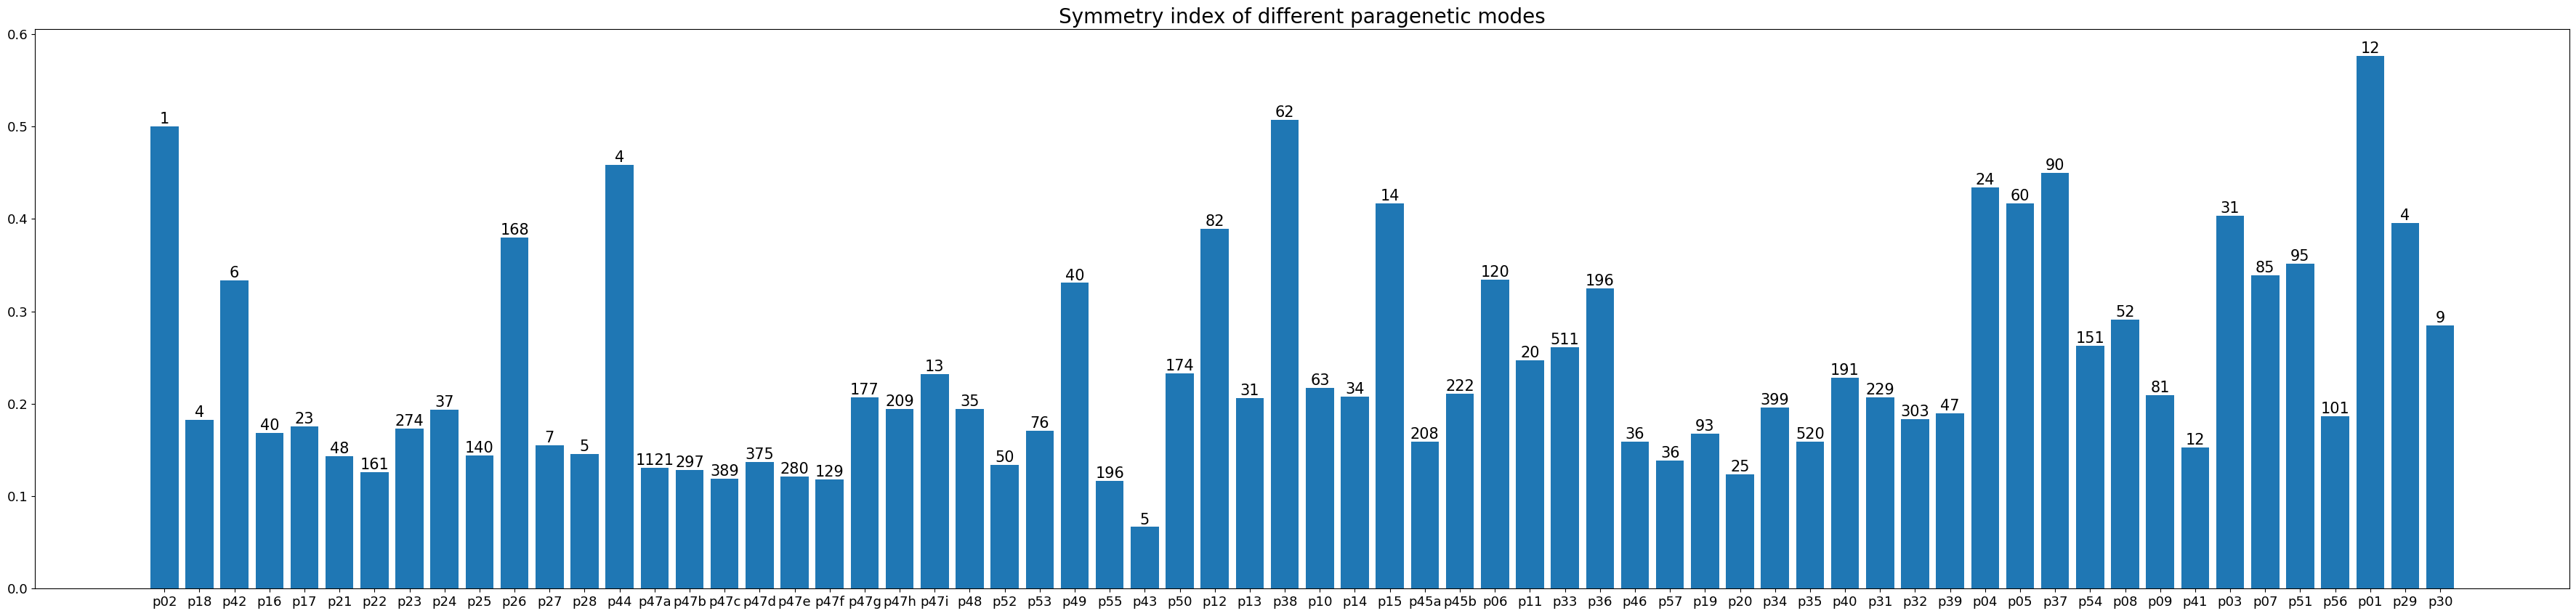

In [11]:
t_max_ordering = sorted(default_ordering, key=lambda p: get_attr(p, T_MAX))
plot_pgm(t_max_ordering, 'graph_pgm_tmax_1', n_plots=1, nums=True)

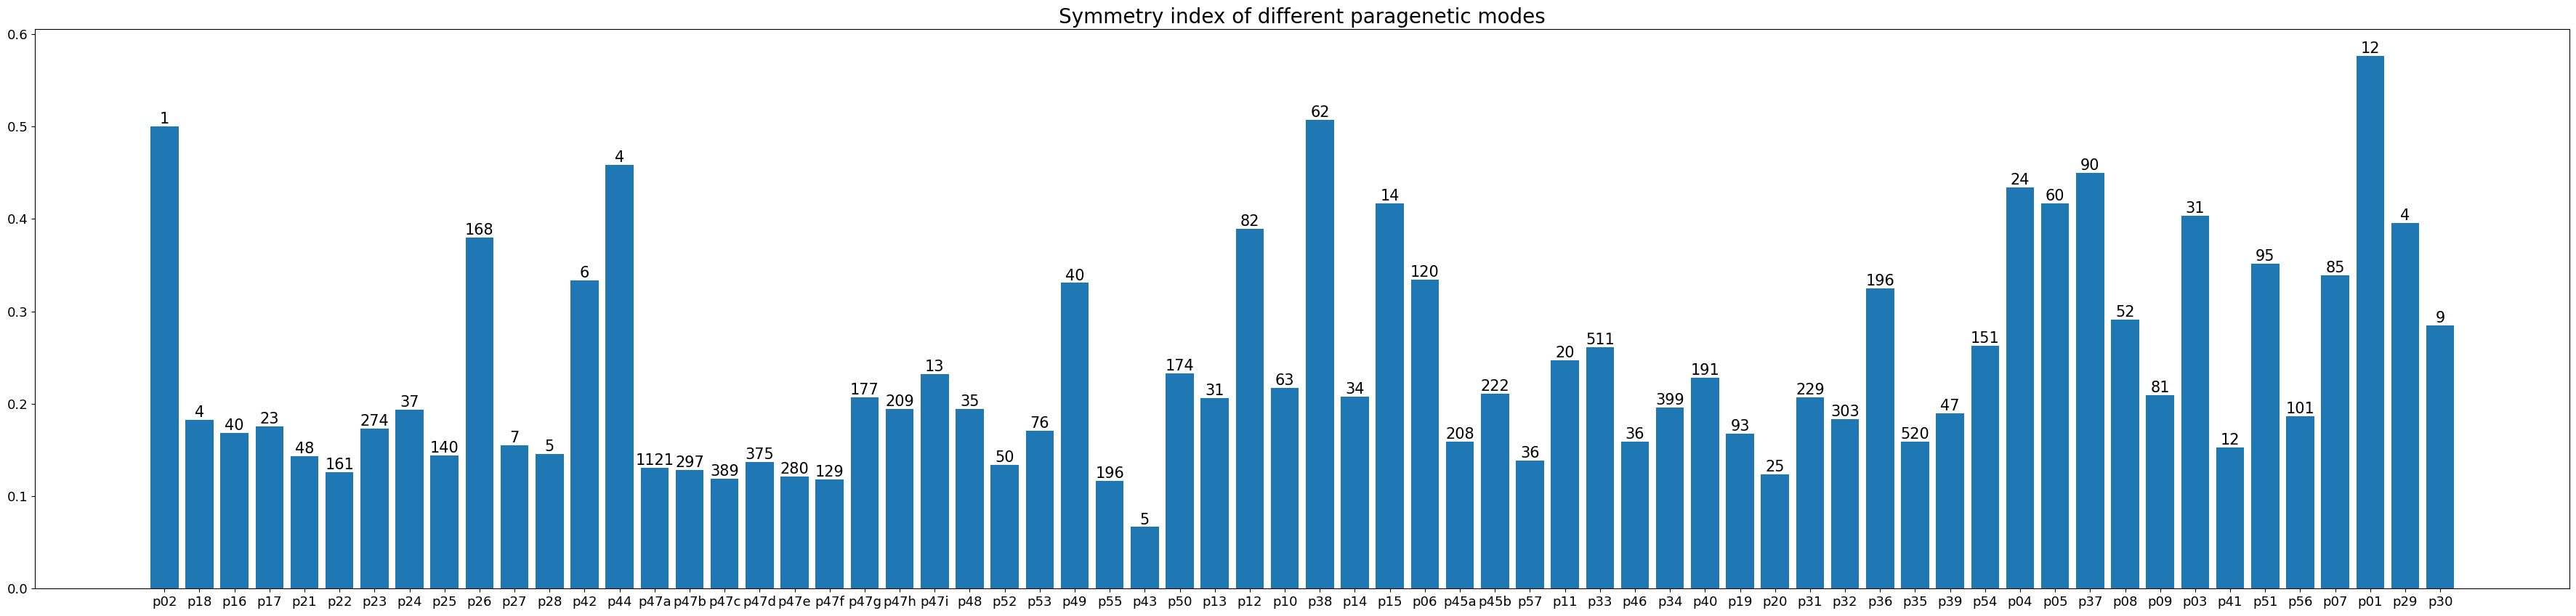

In [12]:
t_avg_ordering = sorted(default_ordering, key=lambda p: get_attr(p, T_AVG))
plot_pgm(t_avg_ordering, 'graph_pgm_tavg_1', n_plots=1, nums=True)

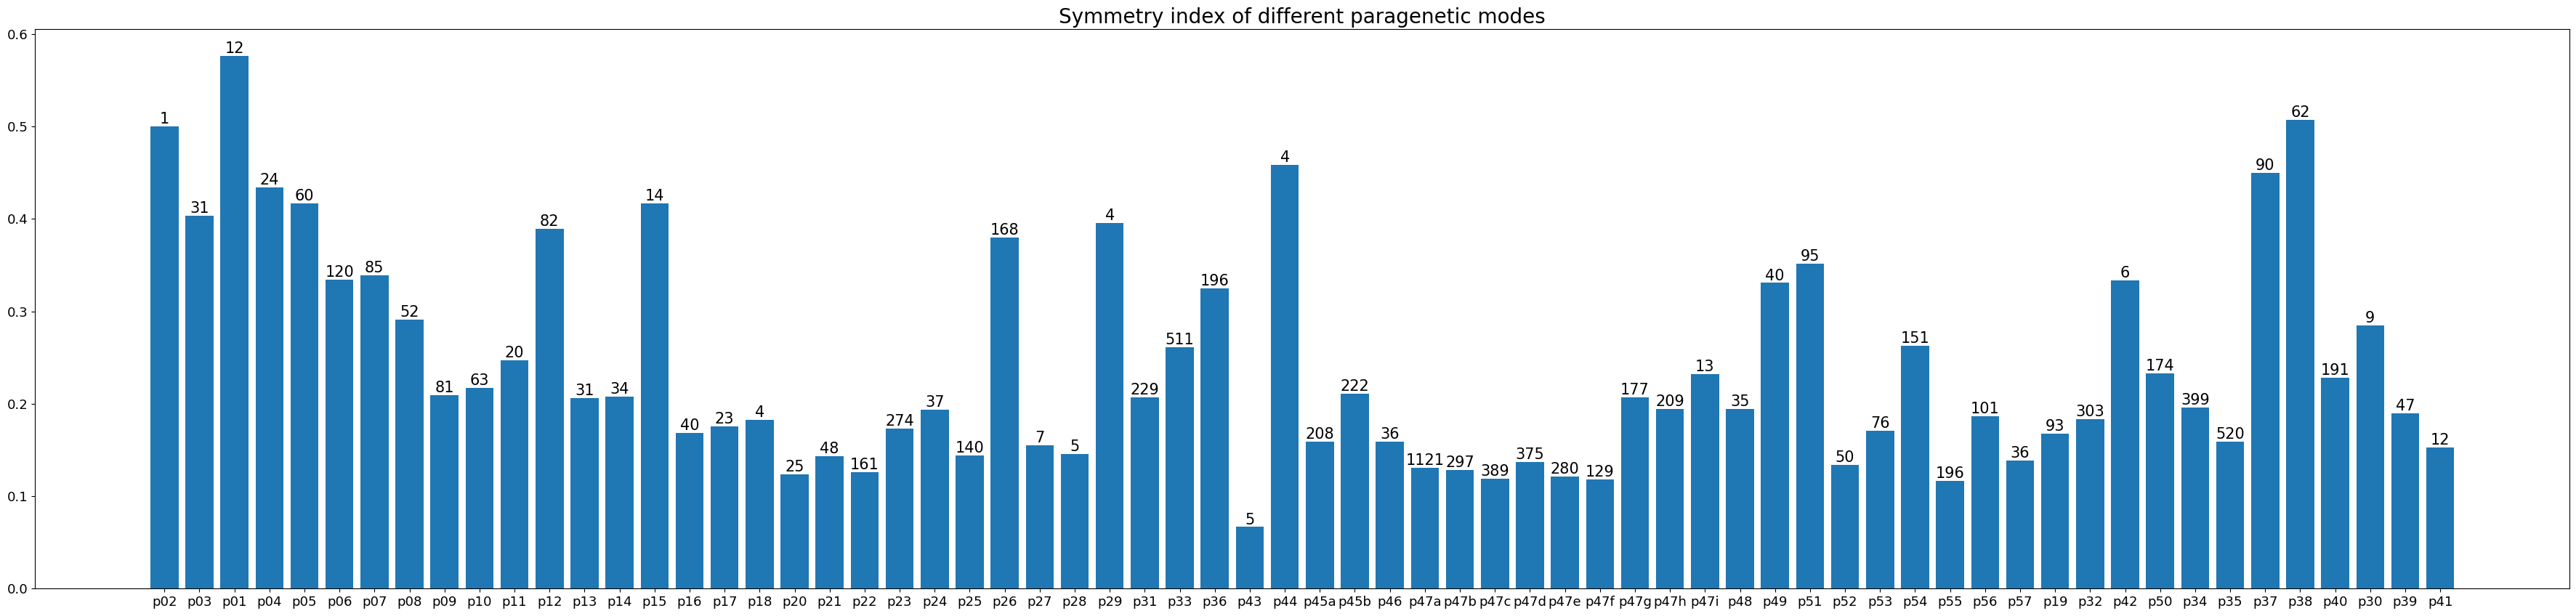

In [13]:
p_min_ordering = sorted(default_ordering, key=lambda p: get_attr(p, P_MIN))
plot_pgm(p_min_ordering, 'graph_pgm_pmin_1', n_plots=1, nums=True)

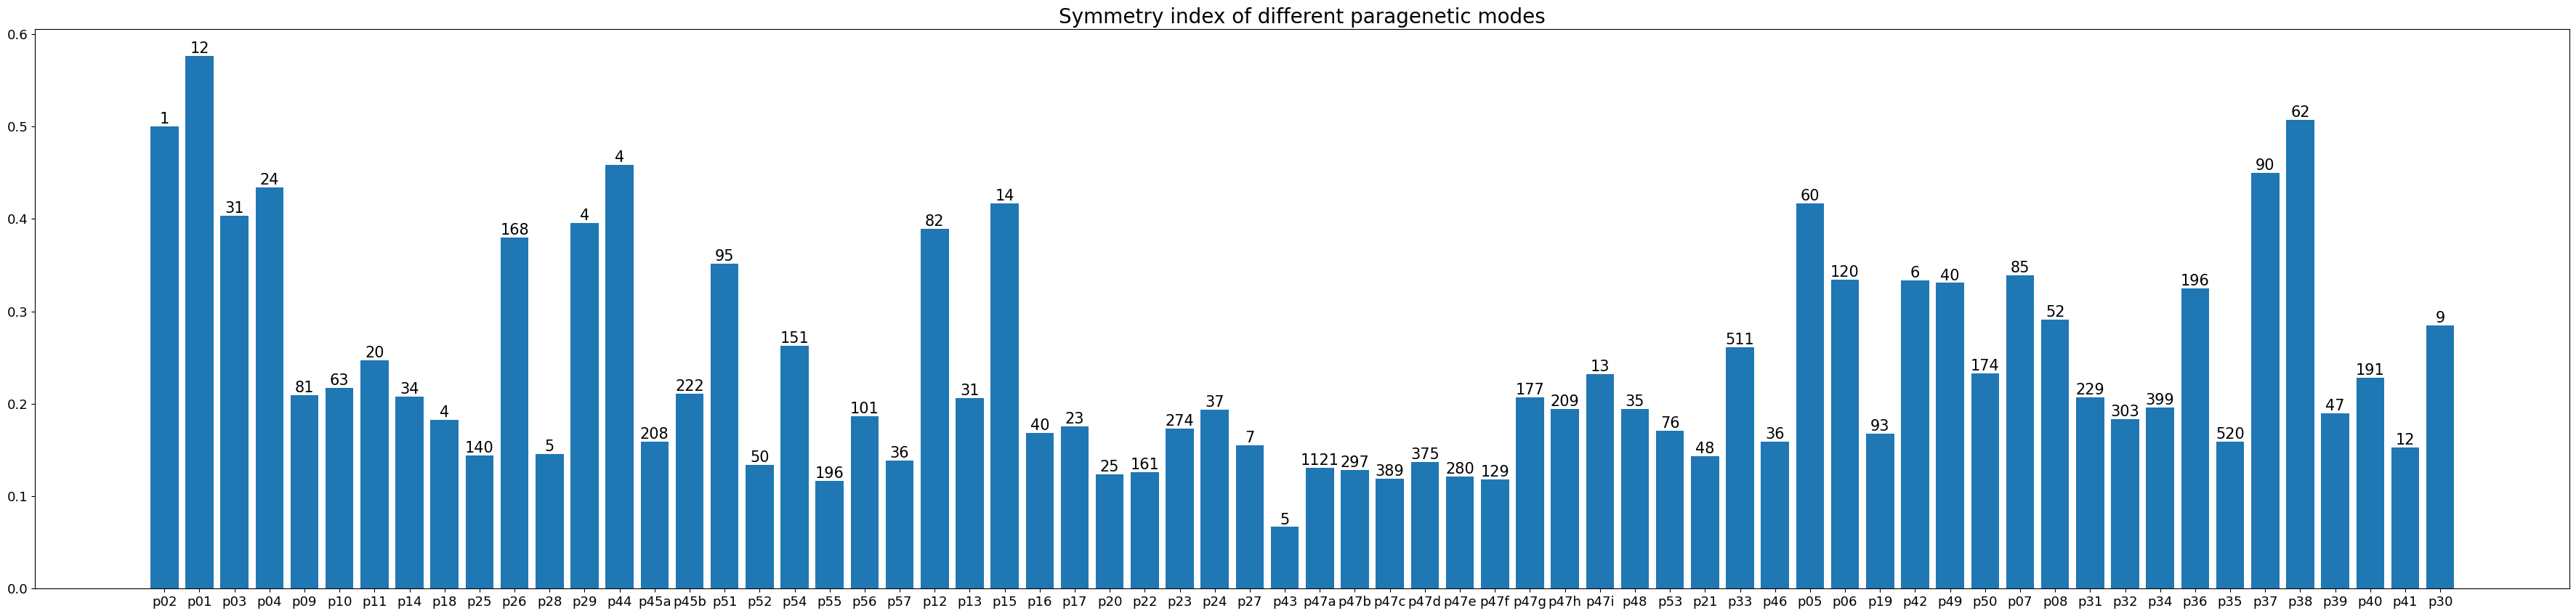

In [14]:
p_max_ordering = sorted(default_ordering, key=lambda p: get_attr(p, P_MAX))
plot_pgm(p_max_ordering, 'graph_pgm_pmax_1', n_plots=1, nums=True)

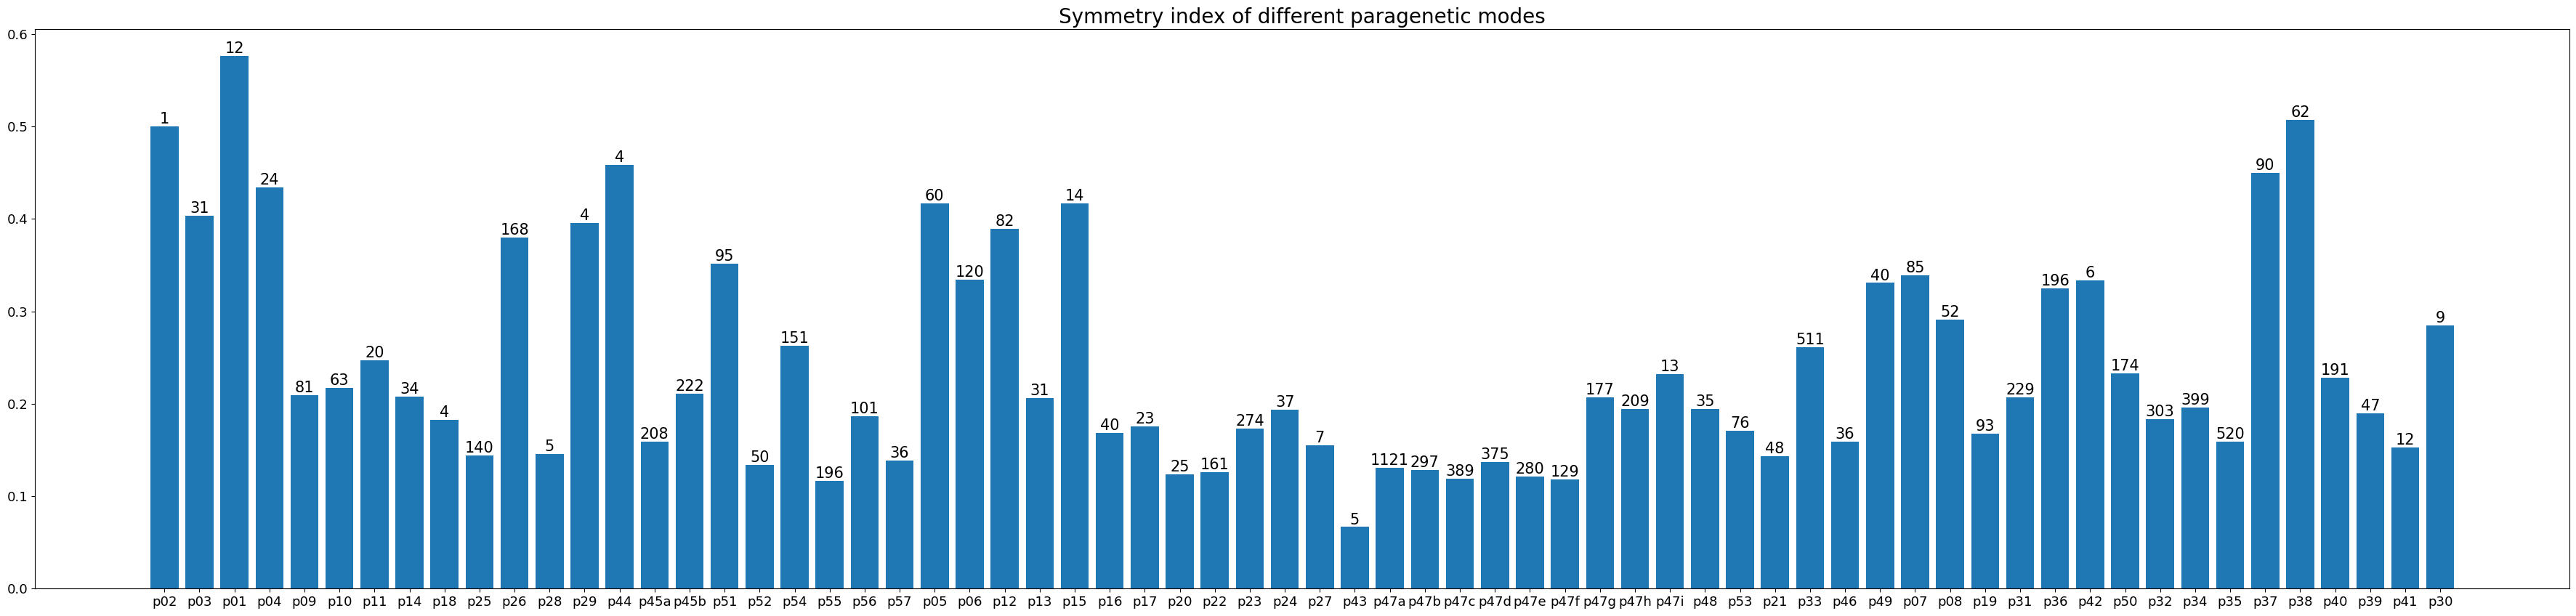

In [15]:
p_avg_ordering = sorted(default_ordering, key=lambda p: get_attr(p, P_AVG))
plot_pgm(p_avg_ordering, 'graph_pgm_pavg_1', n_plots=1, nums=True)

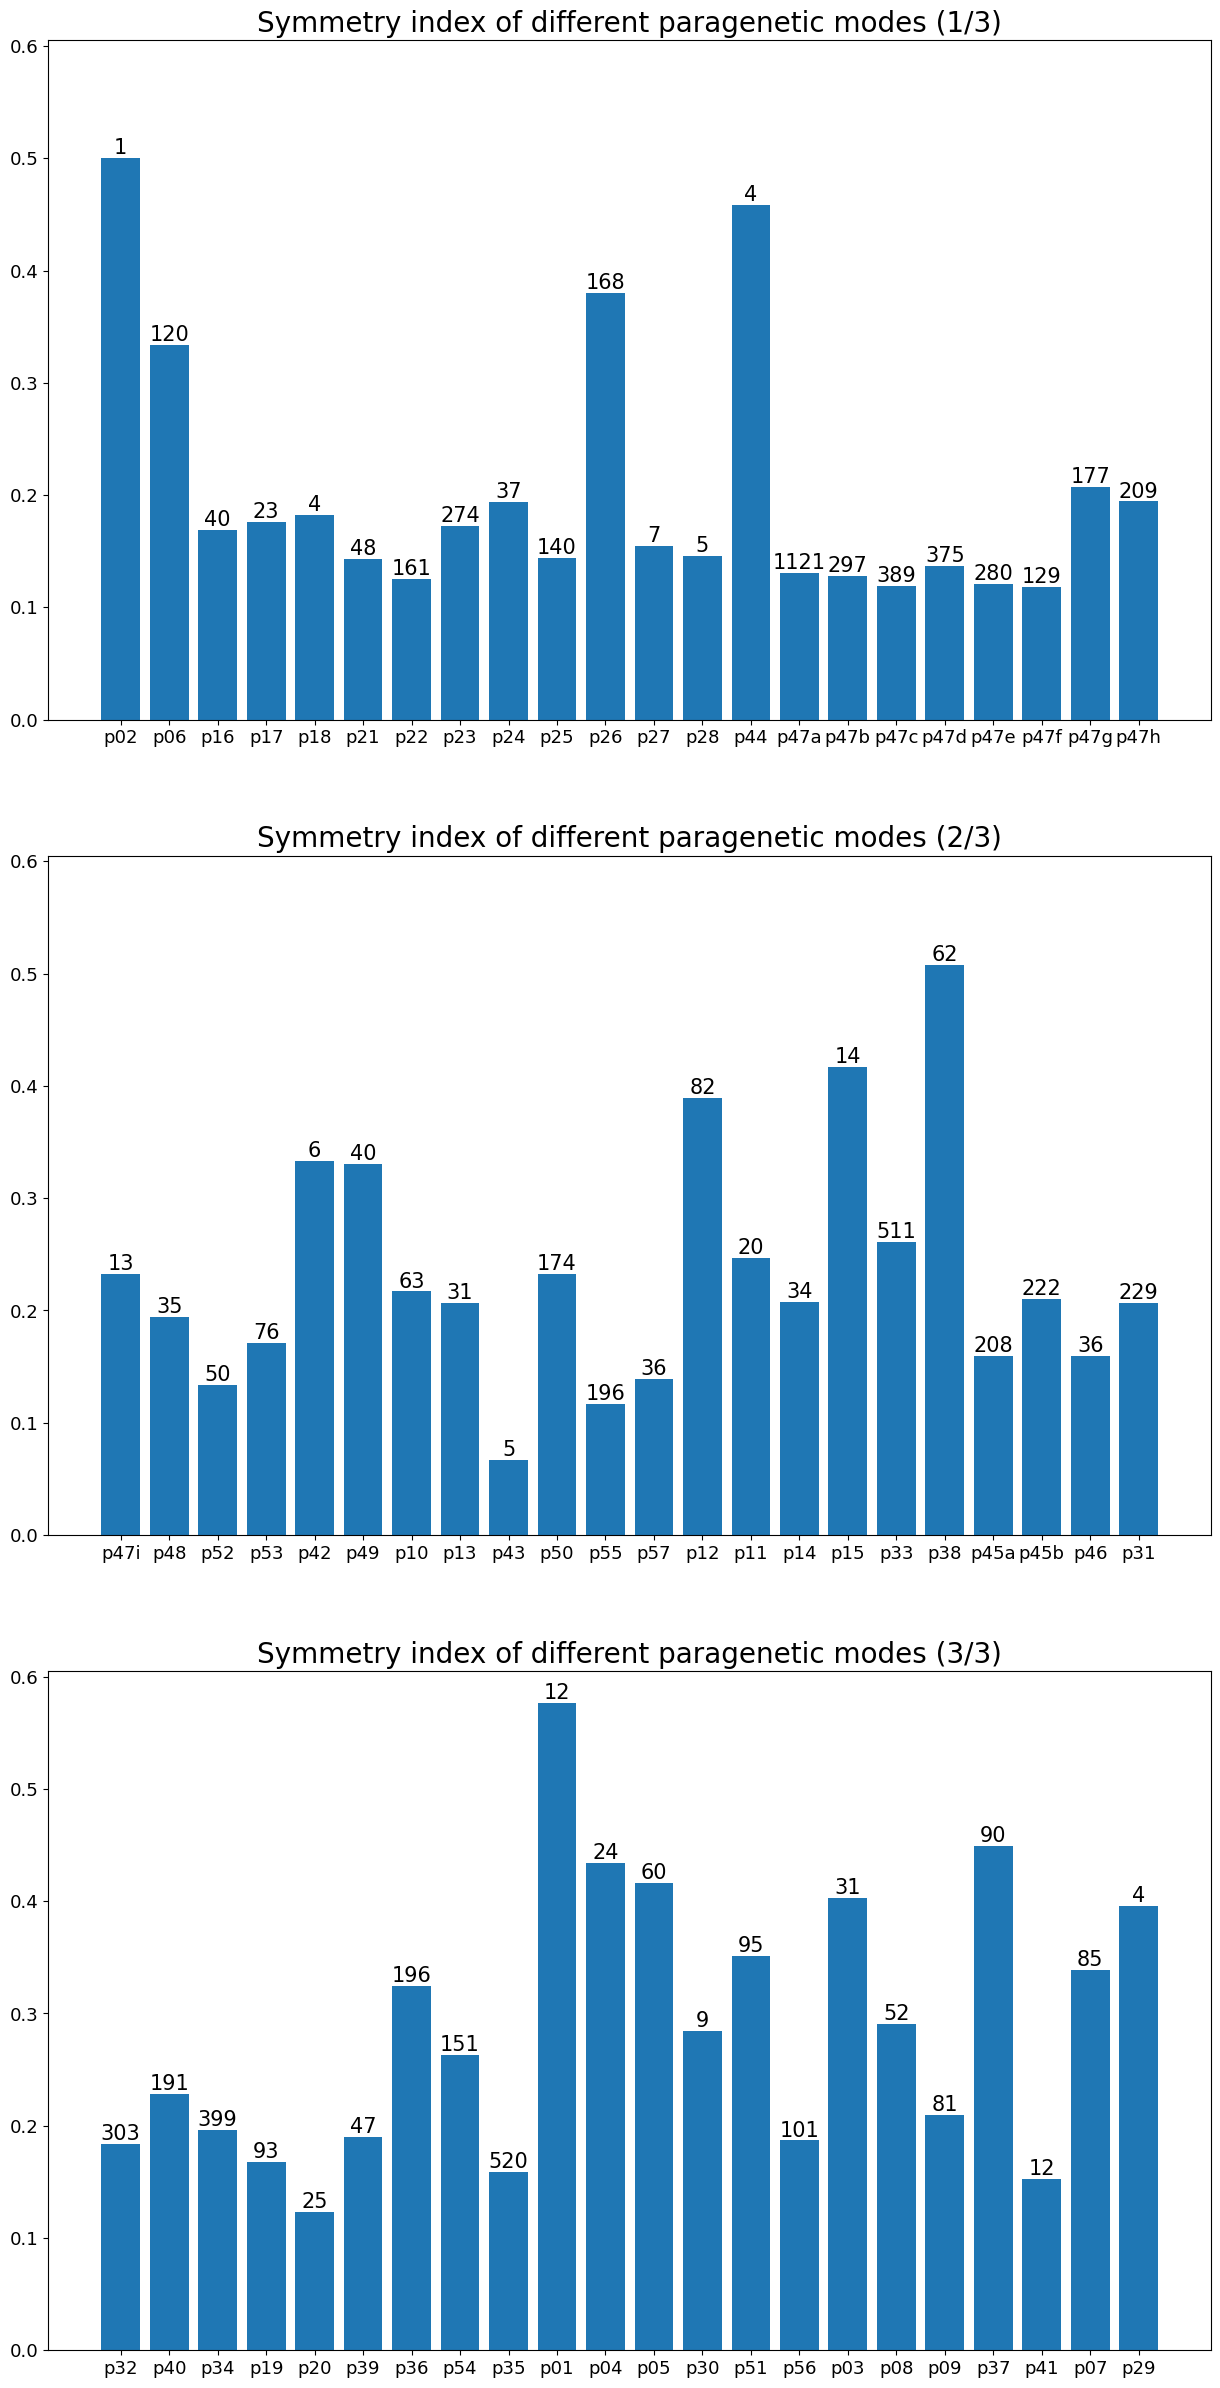

In [16]:
t_min_ordering = sorted(default_ordering, key=lambda p: get_attr(p, T_MIN))
plot_pgm(t_min_ordering, 'graph_pgm_tmin', nums=True)

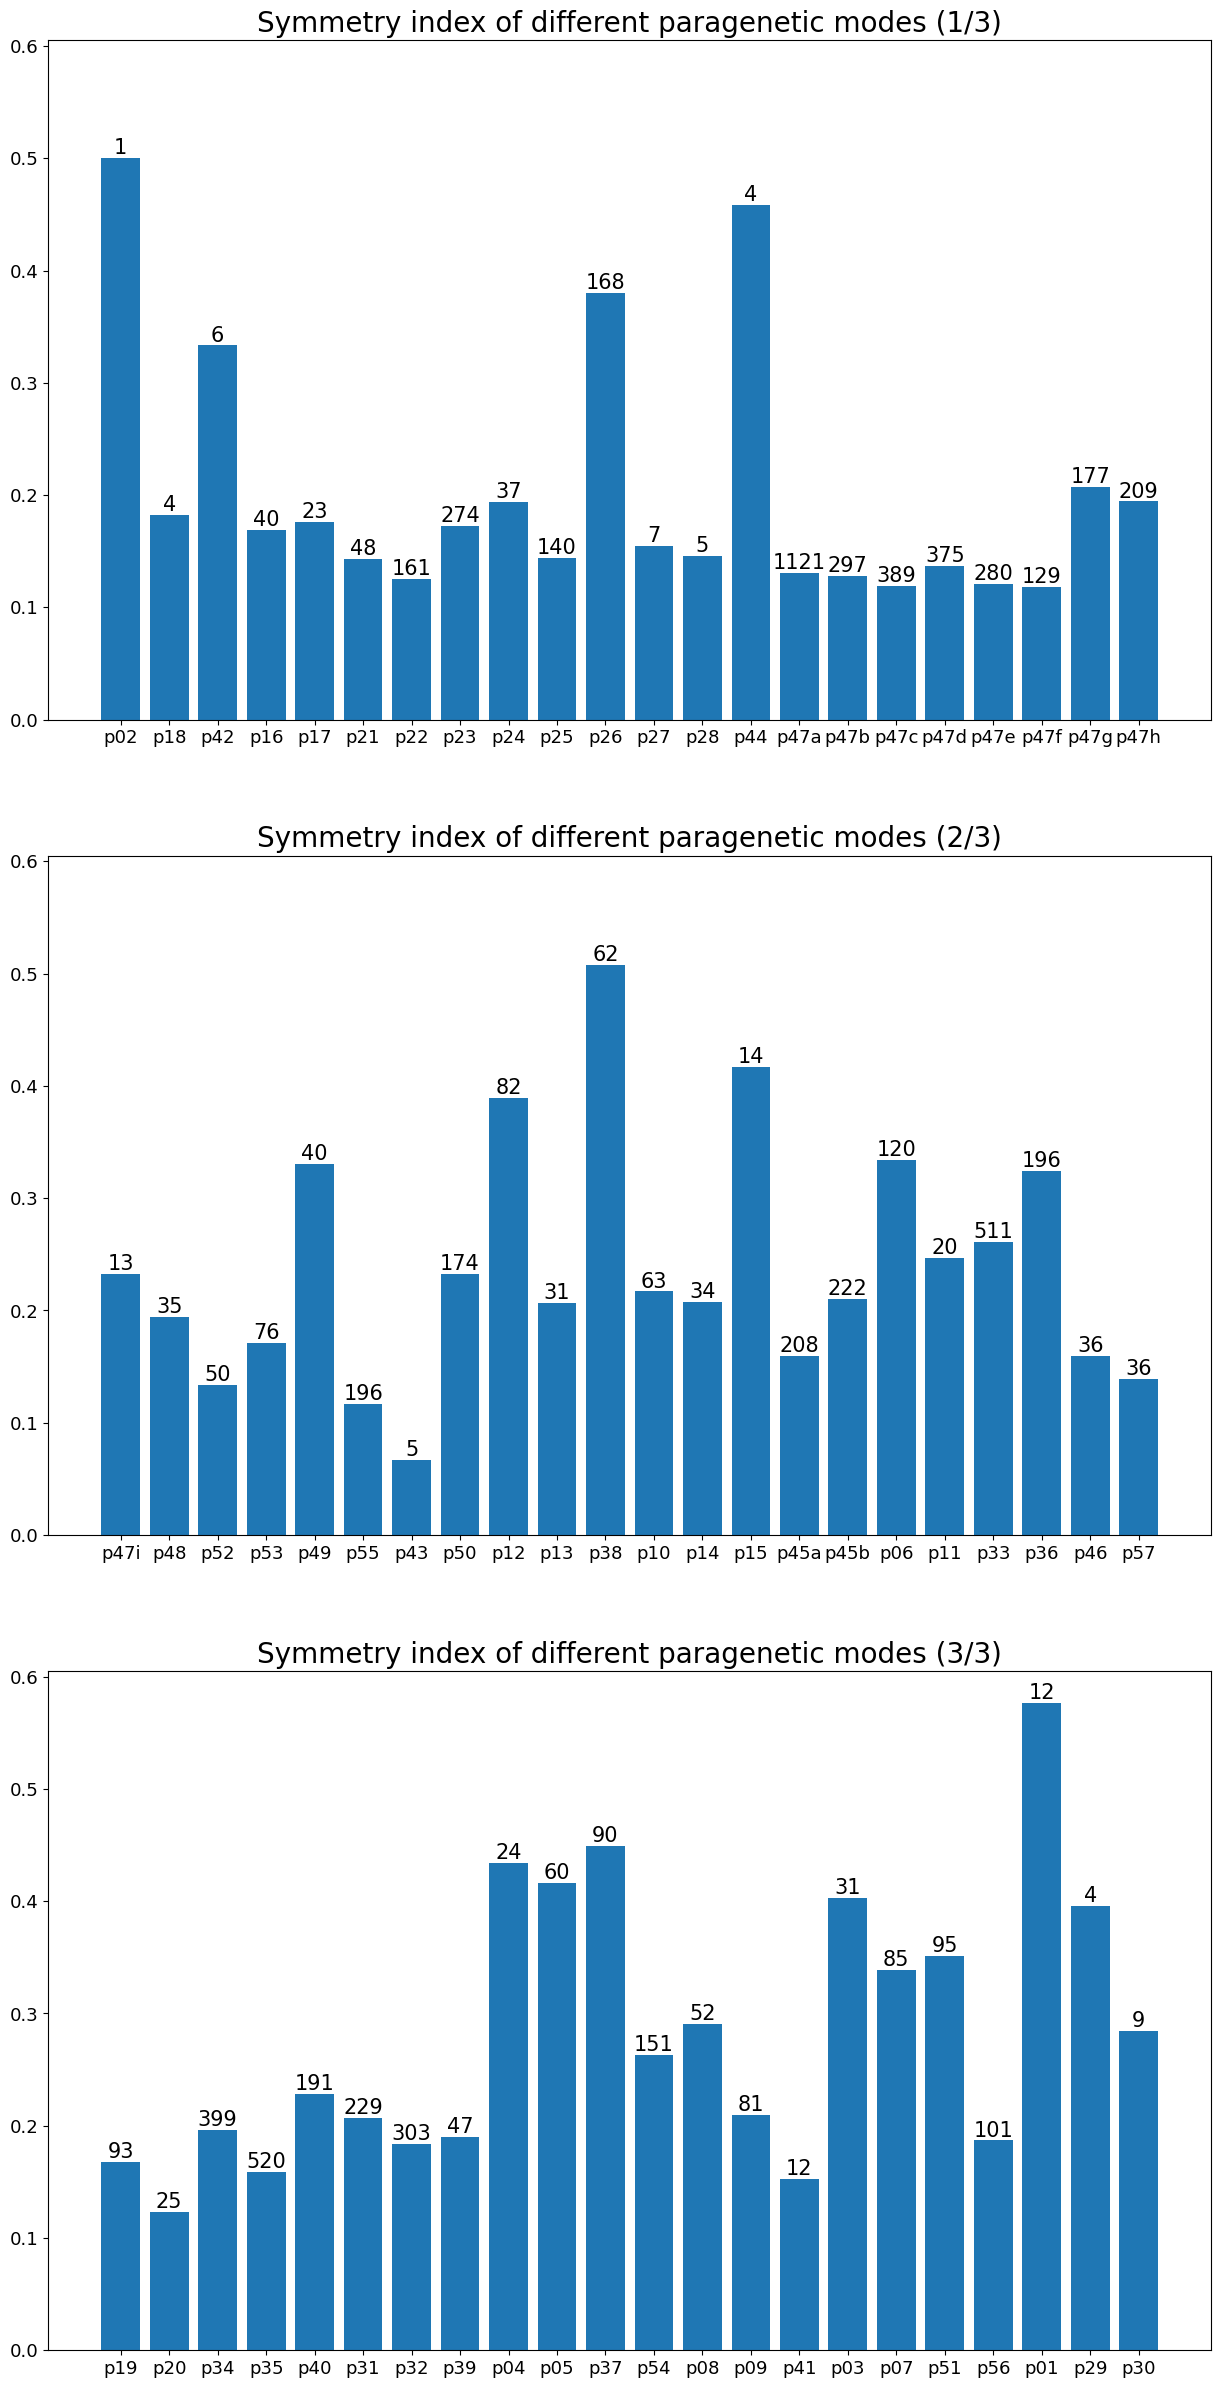

In [17]:
t_max_ordering = sorted(default_ordering, key=lambda p: get_attr(p, T_MAX))
plot_pgm(t_max_ordering, 'graph_pgm_tmax', nums=True)

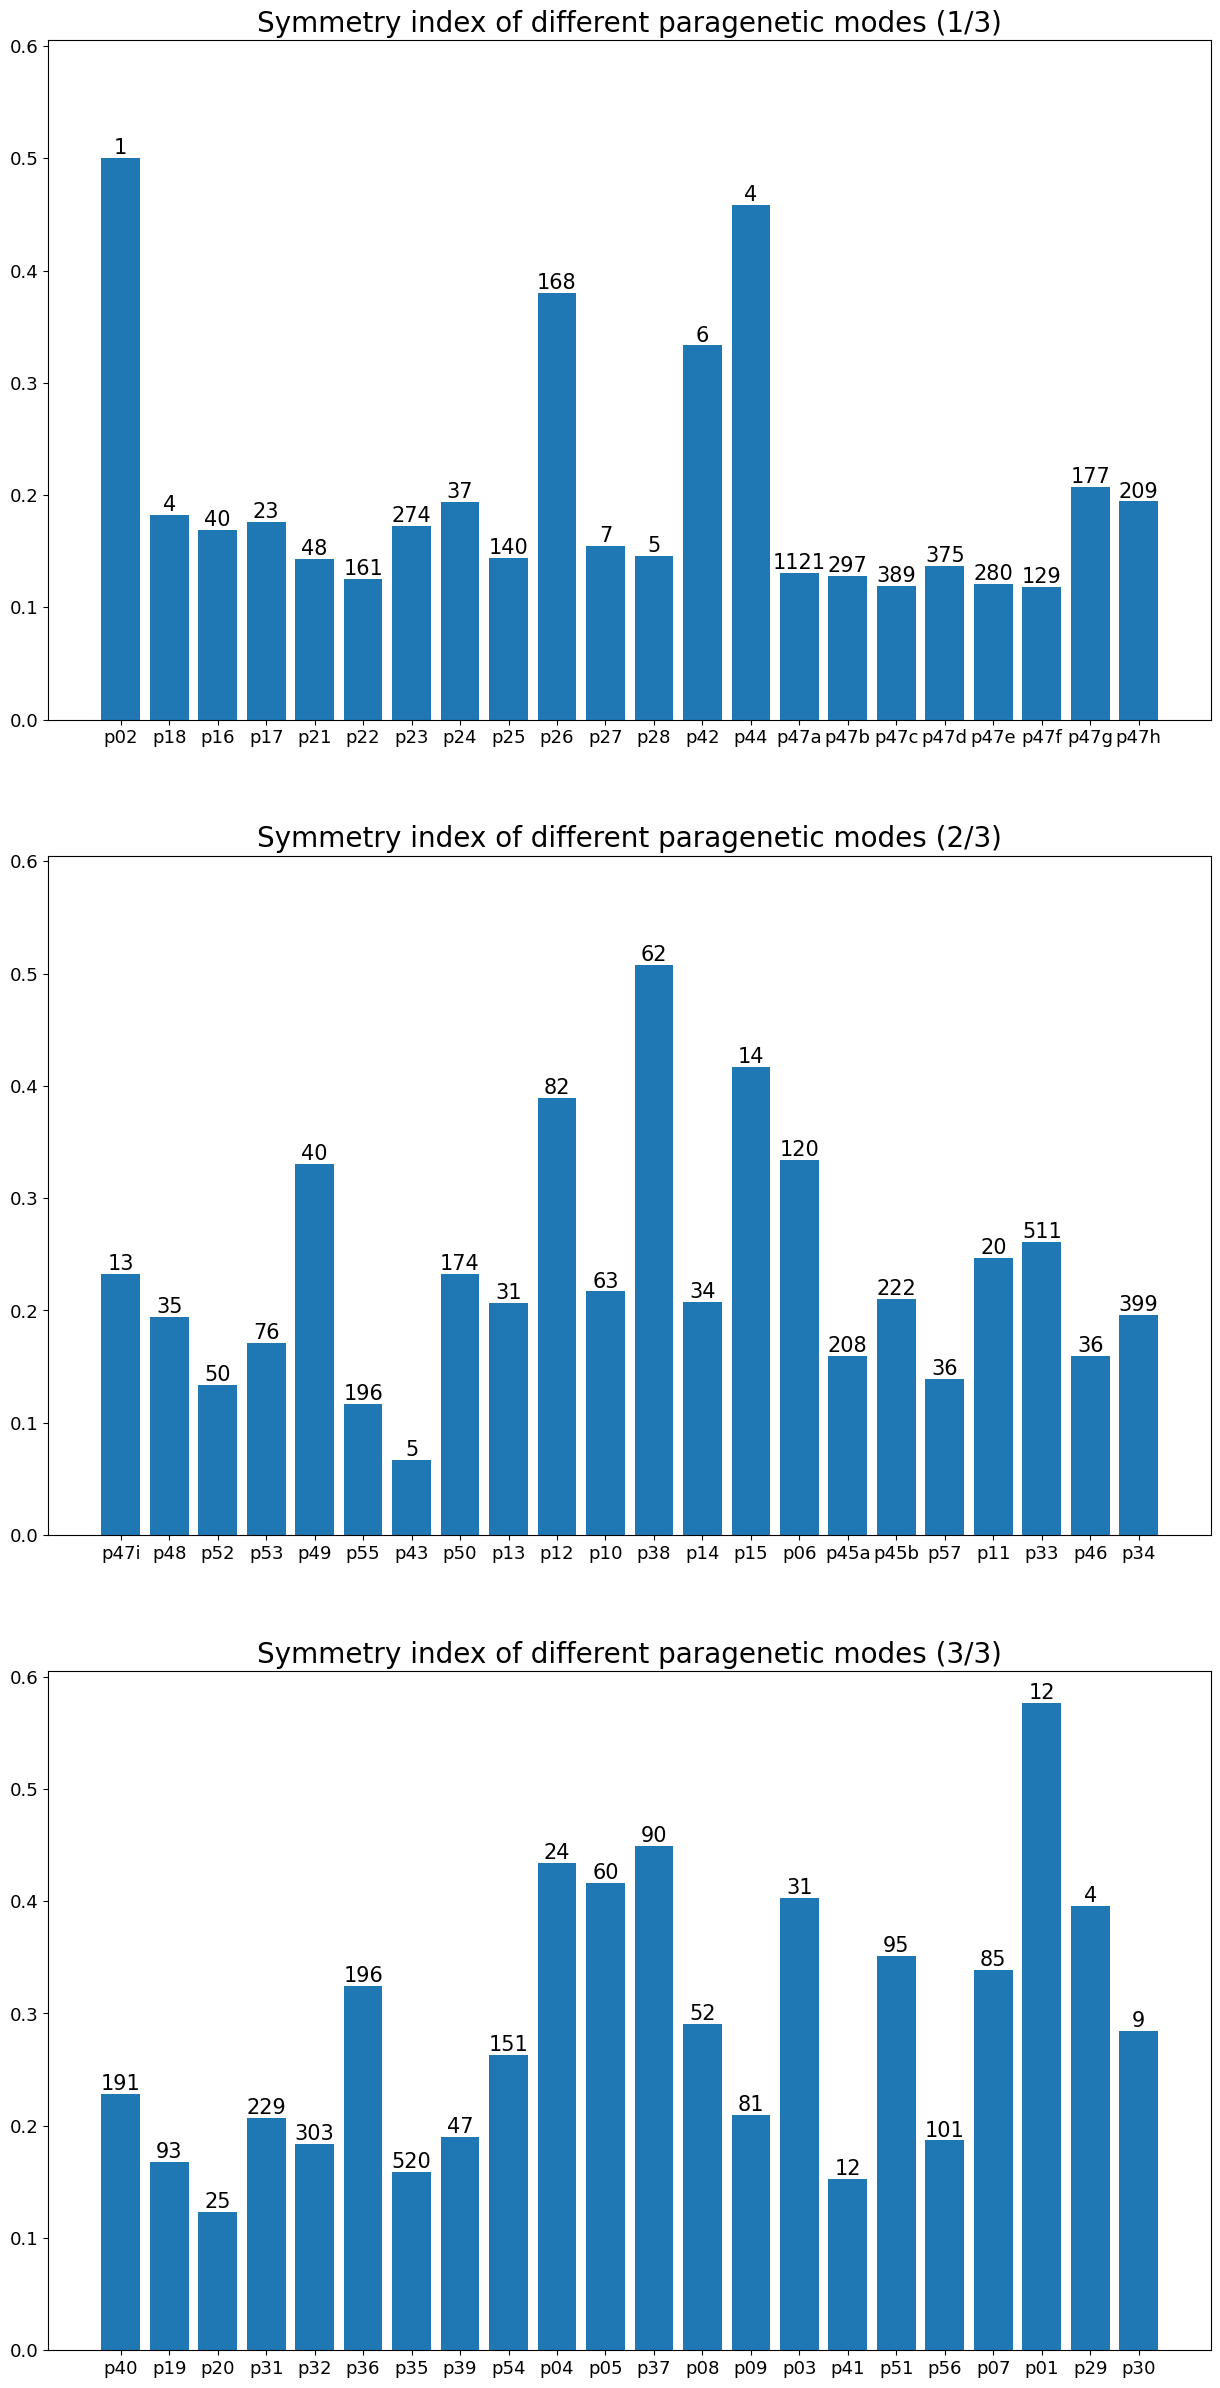

In [18]:
t_avg_ordering = sorted(default_ordering, key=lambda p: get_attr(p, T_AVG))
plot_pgm(t_avg_ordering, 'graph_pgm_tavg', nums=True)

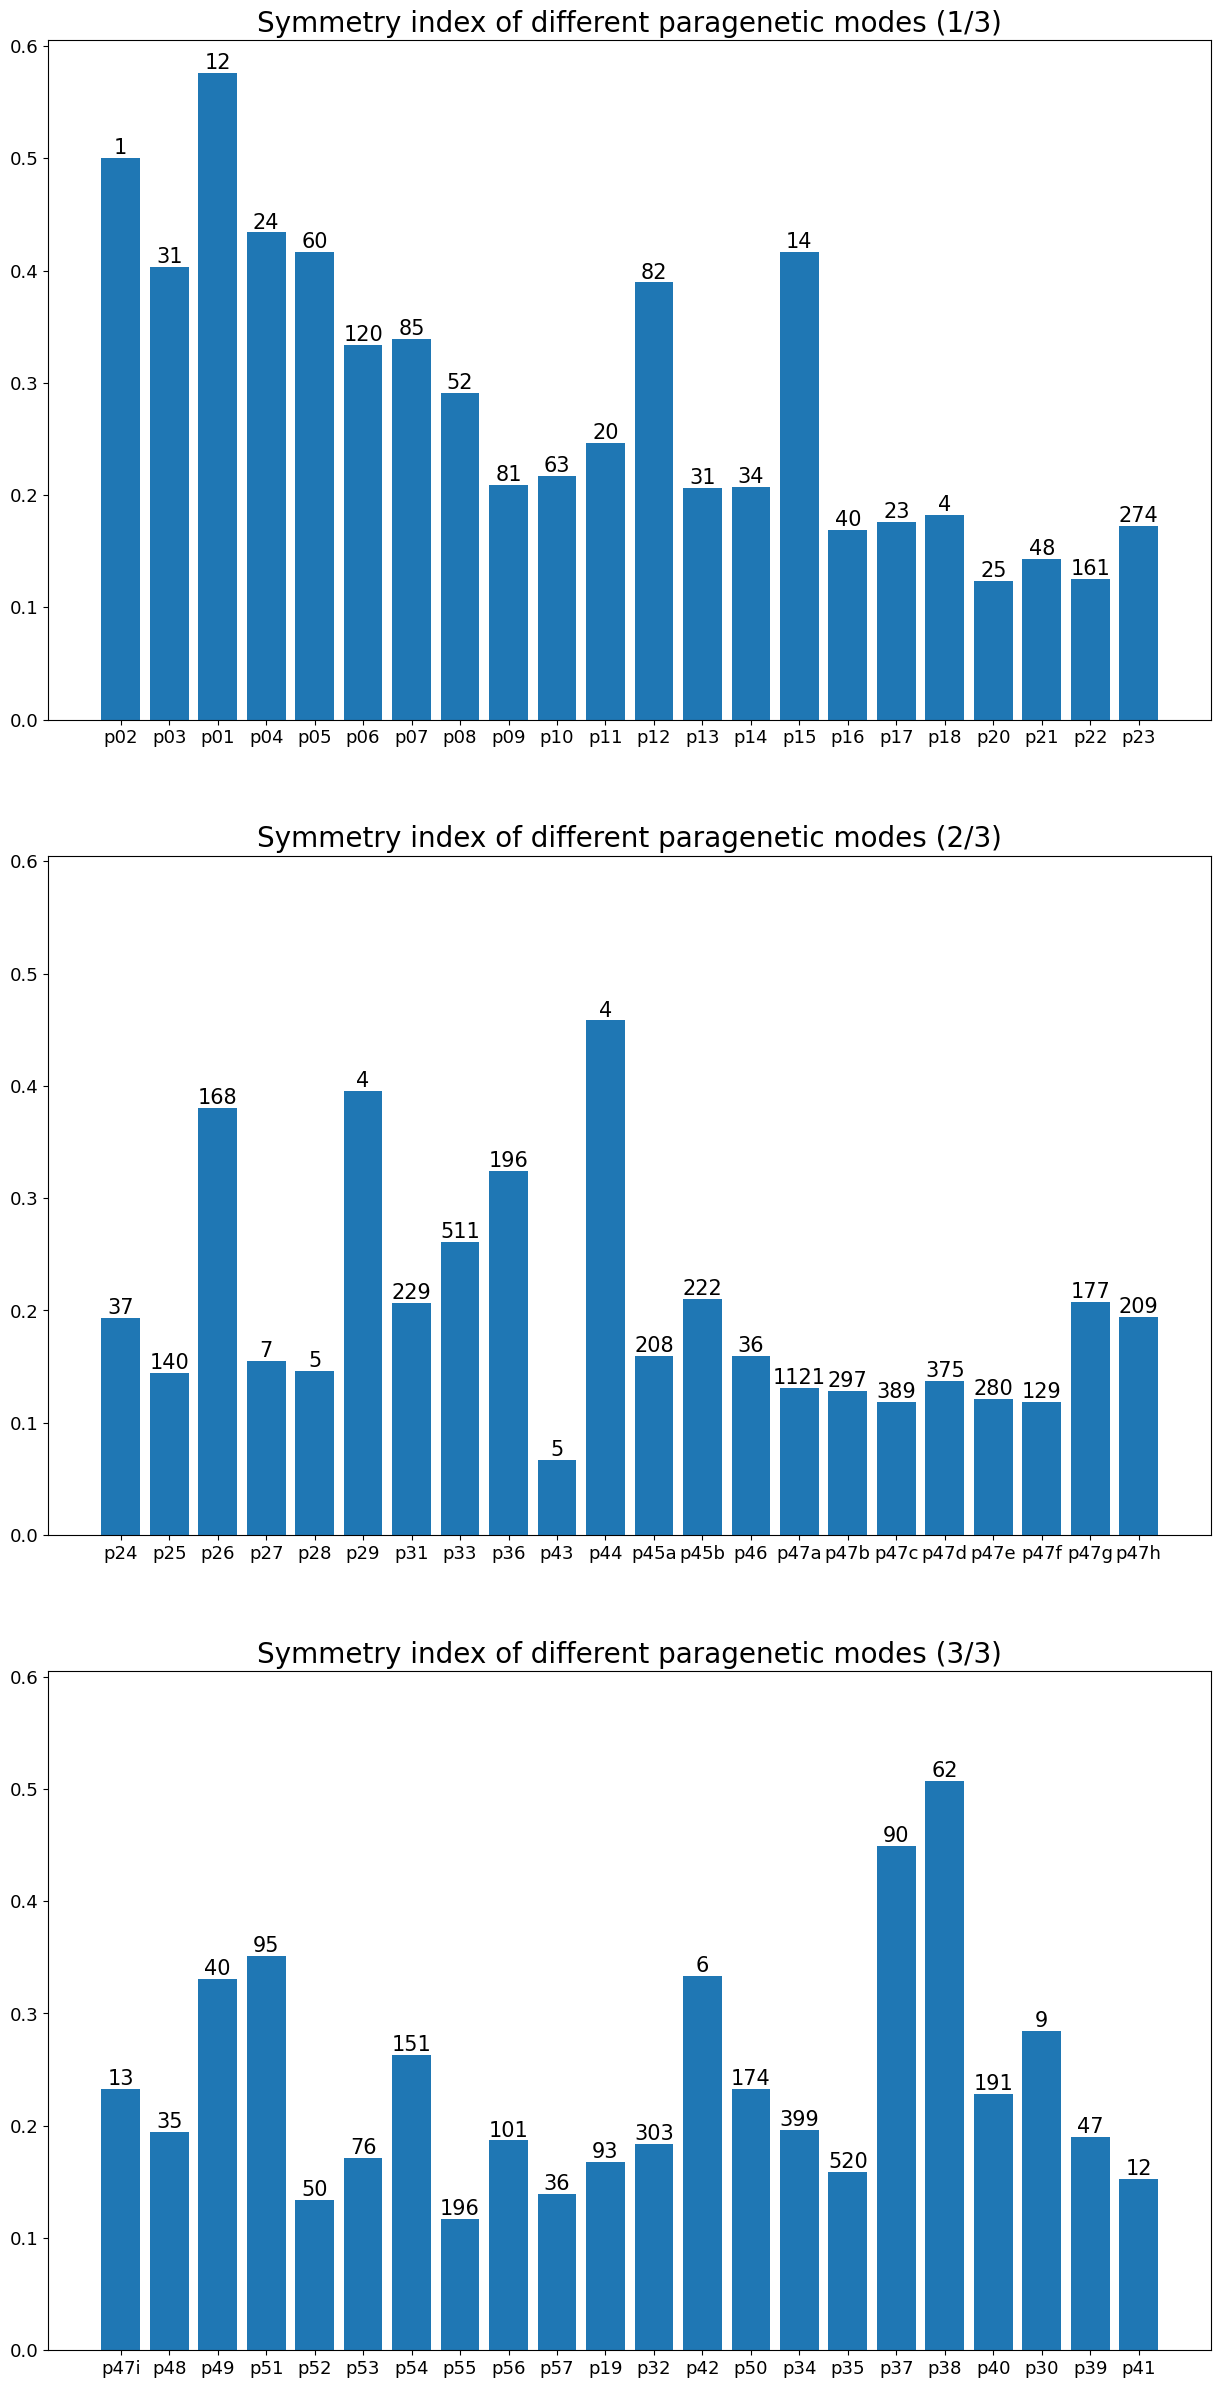

In [19]:
p_min_ordering = sorted(default_ordering, key=lambda p: get_attr(p, P_MIN))
plot_pgm(p_min_ordering, 'graph_pgm_pmin', nums=True)

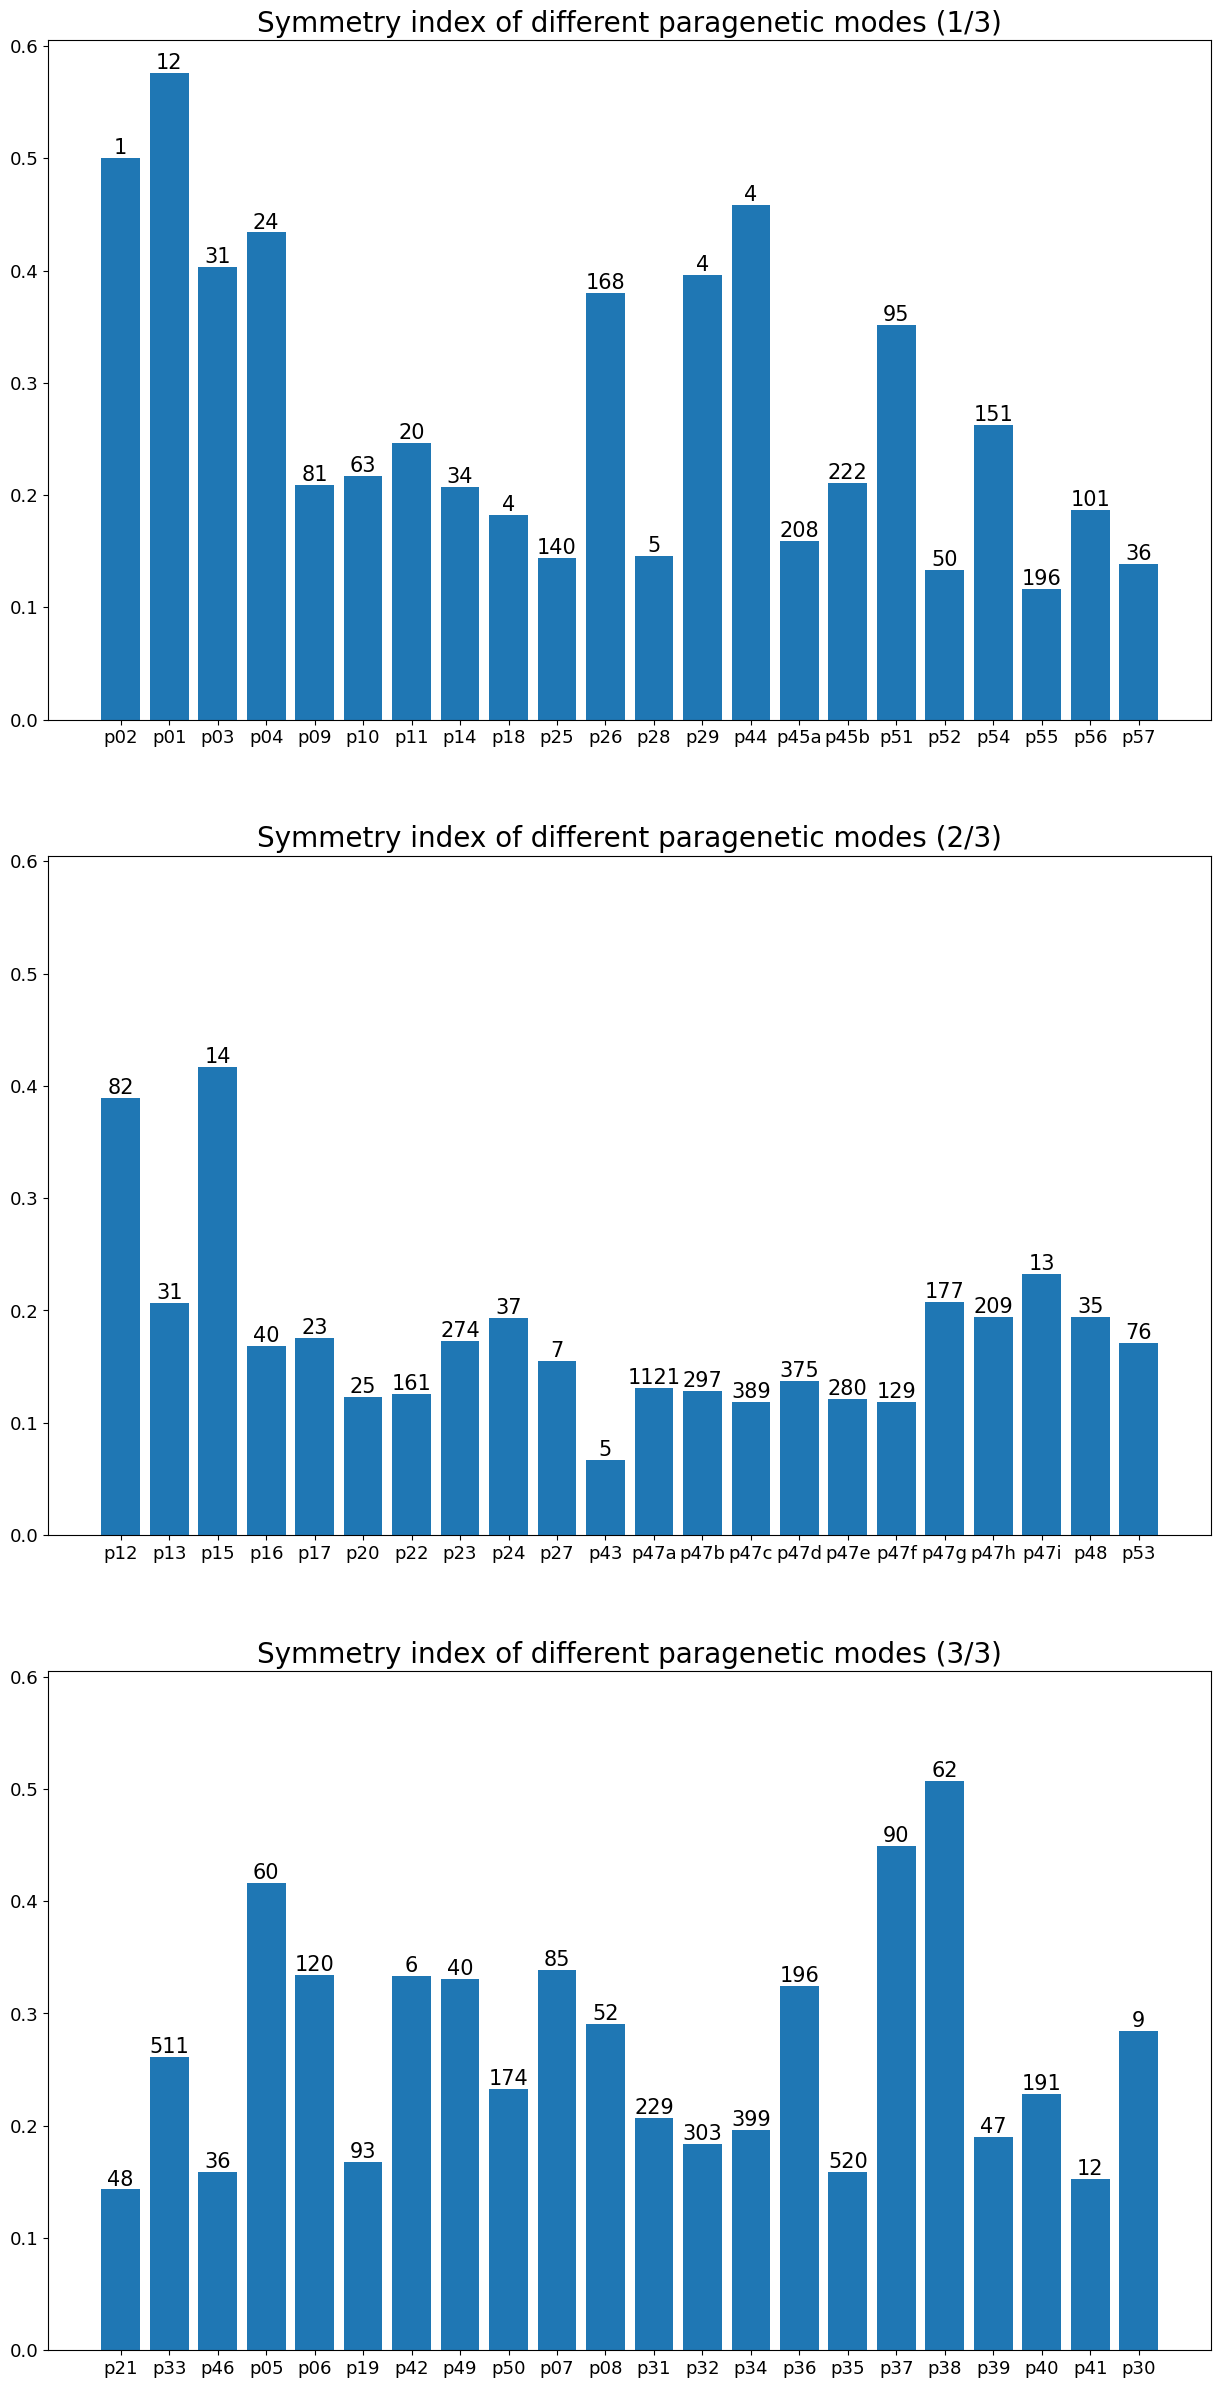

In [20]:
p_max_ordering = sorted(default_ordering, key=lambda p: get_attr(p, P_MAX))
plot_pgm(p_max_ordering, 'graph_pgm_pmax', nums=True)

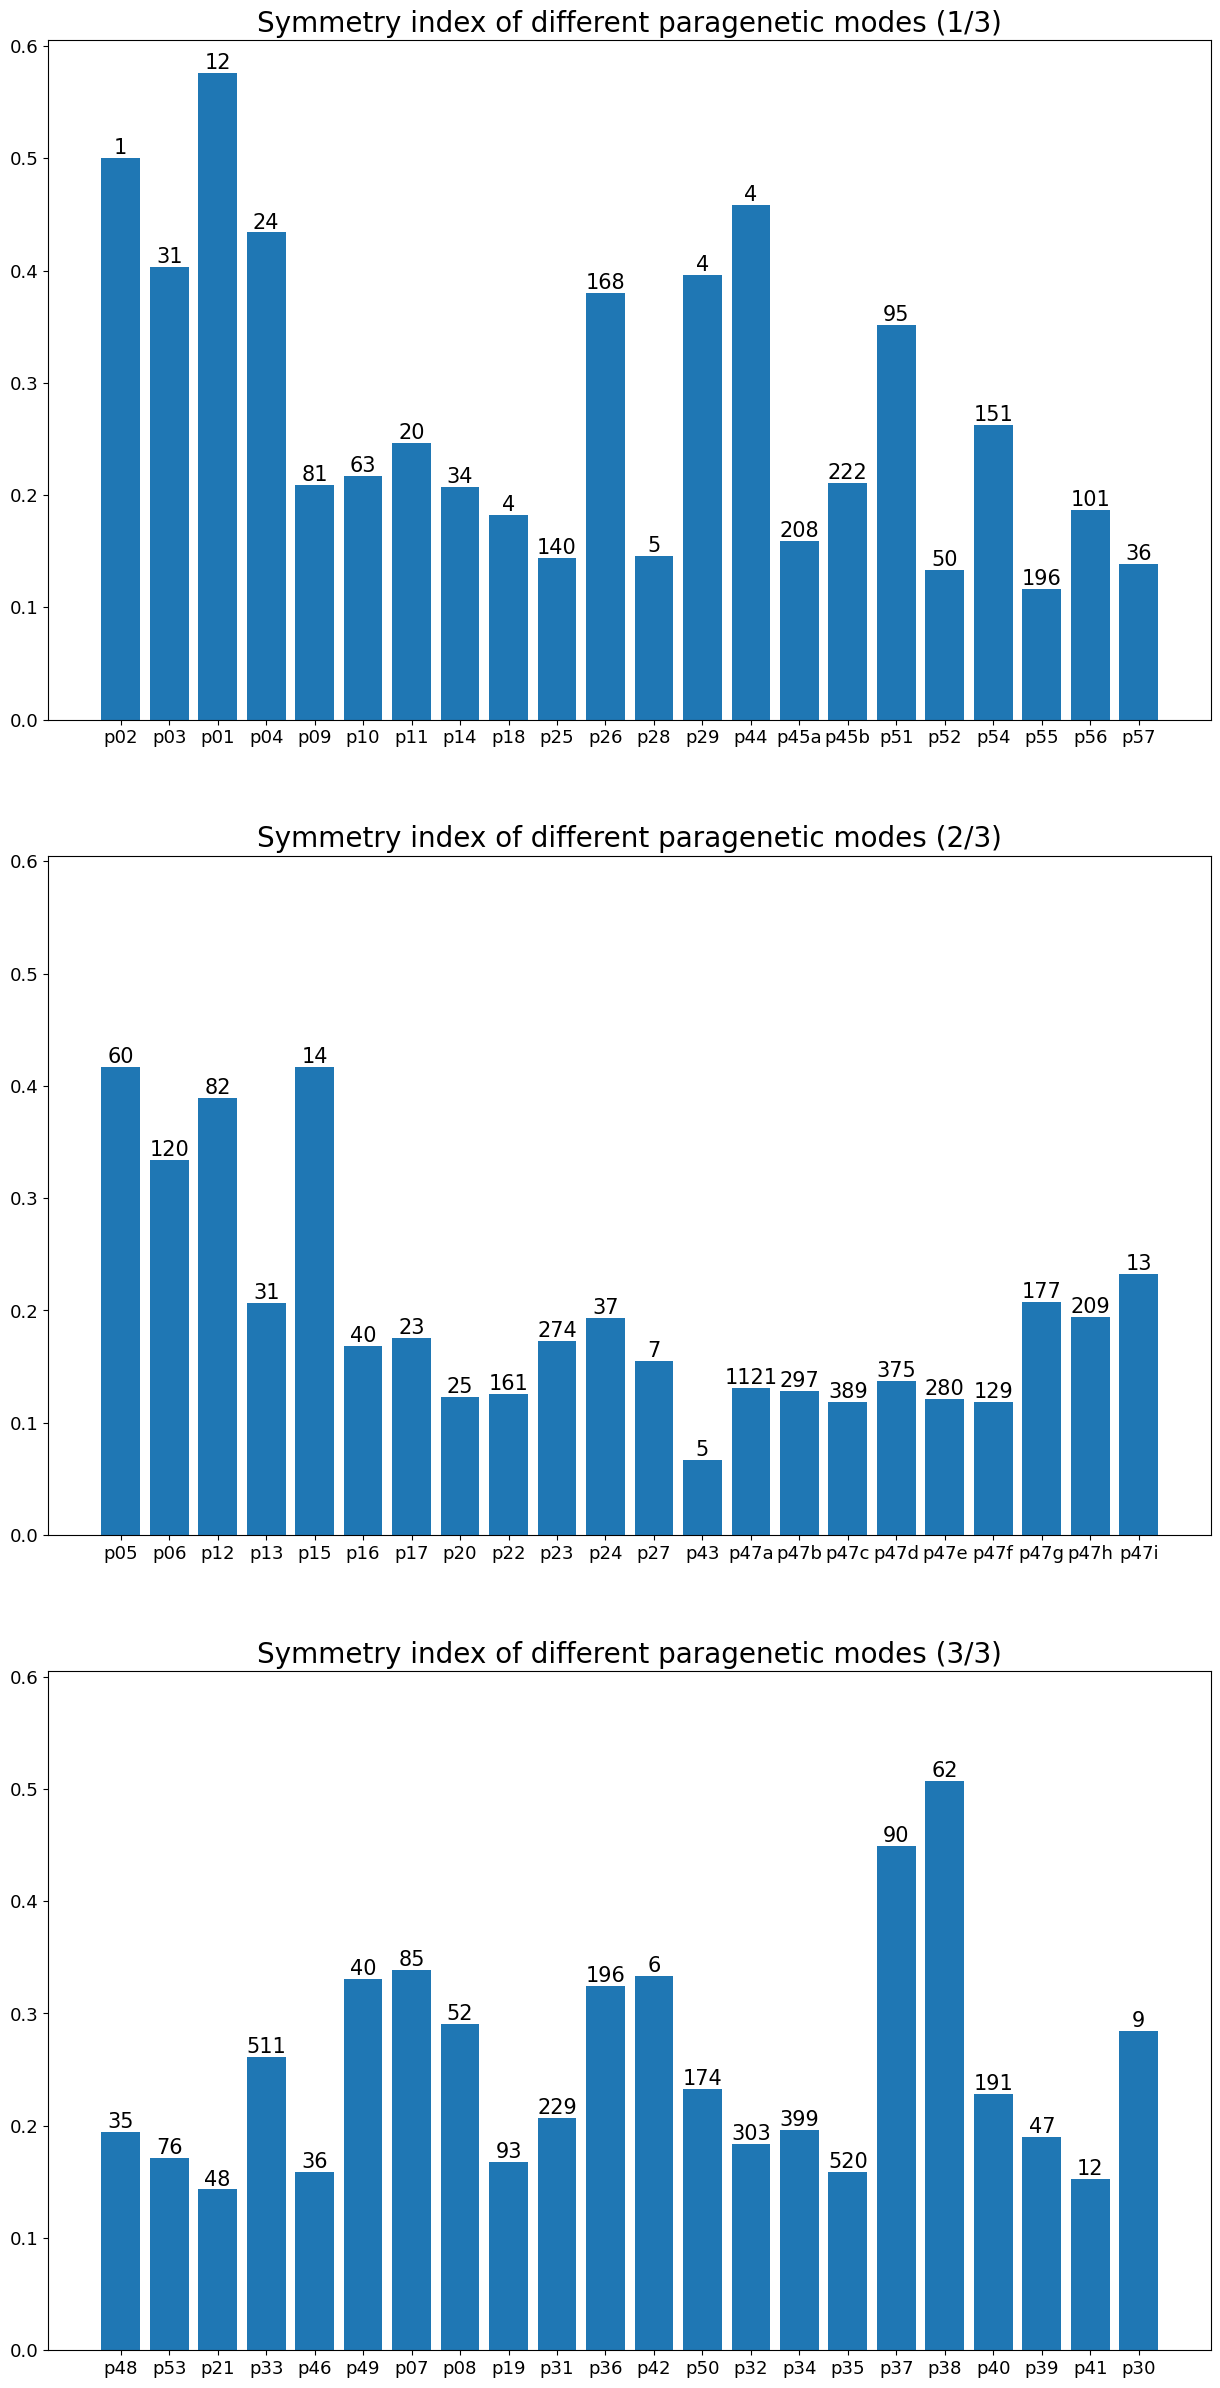

In [21]:
p_avg_ordering = sorted(default_ordering, key=lambda p: get_attr(p, P_AVG))
plot_pgm(p_avg_ordering, 'graph_pgm_pavg', nums=True)

In [22]:
def minerals_in_crit(CRIT):
    ret = {}
    
    for x in db.mineral_coll.find():
        mineral = x['mineral_name']
        
        try:
            pgms = x['pgm']
        except:
            continue
            

        if len(pgms) == 1:
            if pgms[0] in ['Lunar', 'p02']:
                continue
                
            c = get_attr(pgms[0], CRIT)
        elif len(pgms) > 1:
            cs = [ get_attr(pgm, CRIT) for pgm in pgms if pgm not in ['Lunar', 'p02'] ]

            if 'min' in CRIT:
                c = min(cs)
            elif 'max' in CRIT:
                c = max(cs)

        if c in ret.keys():
            ret[c].append(mineral)
        else:
            ret[c] = [ mineral ]
        
    return ret

In [23]:
minerals_in_crit(T_MIN)

{250: ['Abellaite',
  'Abelsonite',
  'Abernathyite',
  'Abhurite',
  'Abuite',
  'Actinolite',
  'Acuminite',
  'Adamite',
  'Adamsite-(Y)',
  'Adanite',
  'Adelite',
  'Admontite',
  'Adolfpateraite',
  'Aegirine',
  'Aegirine-augite',
  'Aerugite',
  'Afmite',
  'Agaite',
  'Agardite-(Ce)',
  'Agardite-(La)',
  'Agardite-(Nd)',
  'Agardite-(Y)',
  'Agricolaite',
  'Agrinierite',
  'Aheylite',
  'Ahlfeldite',
  'Ajoite',
  'Akaganeite',
  'Akdalaite',
  'Akhtenskite',
  'Akopovaite',
  'Aksaite',
  'Alamosite',
  'Albertiniite',
  'Albite',
  'Albrechtschraufite',
  'Alcantarillaite',
  'Alcaparrosaite',
  'Aldermanite',
  'Aldridgeite',
  'Aleksandrovite',
  'Alforsite',
  'Alfredopetrovite',
  'Alfredstelznerite',
  'Aliettite',
  'Allanite-(Ce)',
  'Allanpringite',
  'Alleghanyite',
  'Alloclasite',
  'Allophane',
  'Alluaudite',
  'Almandine',
  'Almeidaite',
  'Alpersite',
  'Alstonite',
  'Alterite',
  'Althupite',
  'Aluminite',
  'Aluminoceladonite',
  'Aluminocopiapite',
  '

In [24]:
def sym_ind(CRIT):
    crit_symmetry_indices = {}
    crit_populations = {}
    n_minerals_in_crit = {}
    
    mins_in_crit = minerals_in_crit(CRIT)
    
    for c in mins_in_crit.keys():
        crit_pop = { pg: 0 for pg in symmetry_indices.keys() }
        num_minerals = 0
        crit_sym_ind = 0

        for x in db.mineral_coll.find({ 'mineral_name': { '$in': mins_in_crit[c] } }):
            mineral = x['mineral_name']
            if mineral not in pg_db.columns:
                continue

            pgs = pg_db[mineral]['point group'].strip().replace('; ', ';').split('; ')
            for pg in pgs:
                if pg in symmetry_indices.keys():
                    crit_pop[pg] += 1
                    num_minerals += 1
                    crit_sym_ind += symmetry_indices[pg]
                    
        try:
            crit_symmetry_indices[c] = crit_sym_ind / max(symmetry_indices.values()) / num_minerals
        except Exception as e:
            print(e)

        crit_populations[c] = crit_pop
        n_minerals_in_crit[c] = num_minerals

    crit_symmetry_indices = { crit: crit_symmetry_indices[crit] for crit in sorted(crit_symmetry_indices) }
    
    return crit_symmetry_indices, n_minerals_in_crit, crit_populations

In [25]:
crit_symmetry_indices, n_minerals_in_crit, crit_avg_populations = {}, {}, {}

for CRIT in [ T_MIN, T_MAX, P_MIN, P_MAX ]:
    crit_symmetry_indices[CRIT], n_minerals_in_crit[CRIT], crit_avg_populations[CRIT] = sym_ind(CRIT)

In [26]:
def plot_crit(CRIT, name, n_plots=1, nums=False):
    fig, ax = plt.subplots(n_plots, figsize=(15, 10*n_plots))
    ordering = list(crit_symmetry_indices[CRIT].keys())
    l = len(ordering)//n_plots
    
    if n_plots == 1:
        ax = [ax]
    
    if len(ordering) % n_plots != 0:
        l += 1

    for i in range(n_plots):
        s, e = i*l, (i+1)*l
        
        num_name = f' ({(i+1)}/{n_plots})' if n_plots > 1 else ''
        crit_name = " ".join(CRIT.split()[:2])

        r = len(ordering[s:e])
        bars = ax[i].bar(range(r), [ crit_symmetry_indices[CRIT][p] for p in ordering[s:e] ])
        ax[i].set_xticks(range(r), labels=ordering[s:e])
        ax[i].tick_params(axis='both', labelsize=FS_TICK)
        ax[i].set_title(f'Symmetry index by {crit_name}{num_name}', fontsize=FS_TITLE)
        plt.xlabel(CRIT, fontsize=20)

    # [ print(f'{p}:\t {sym:.3f}') for p, sym in pgm_symmetry_indices.items() ]

        if nums:
            for n_minerals, bar in zip([ n_minerals_in_crit[CRIT][p] for p in ordering[s:e] ], bars):
                ax[i].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                           f'{n_minerals}',
                           ha='center', va='bottom', fontsize=FS_SAMPLE
                          )

    plt.savefig(f'results/{name}.png')

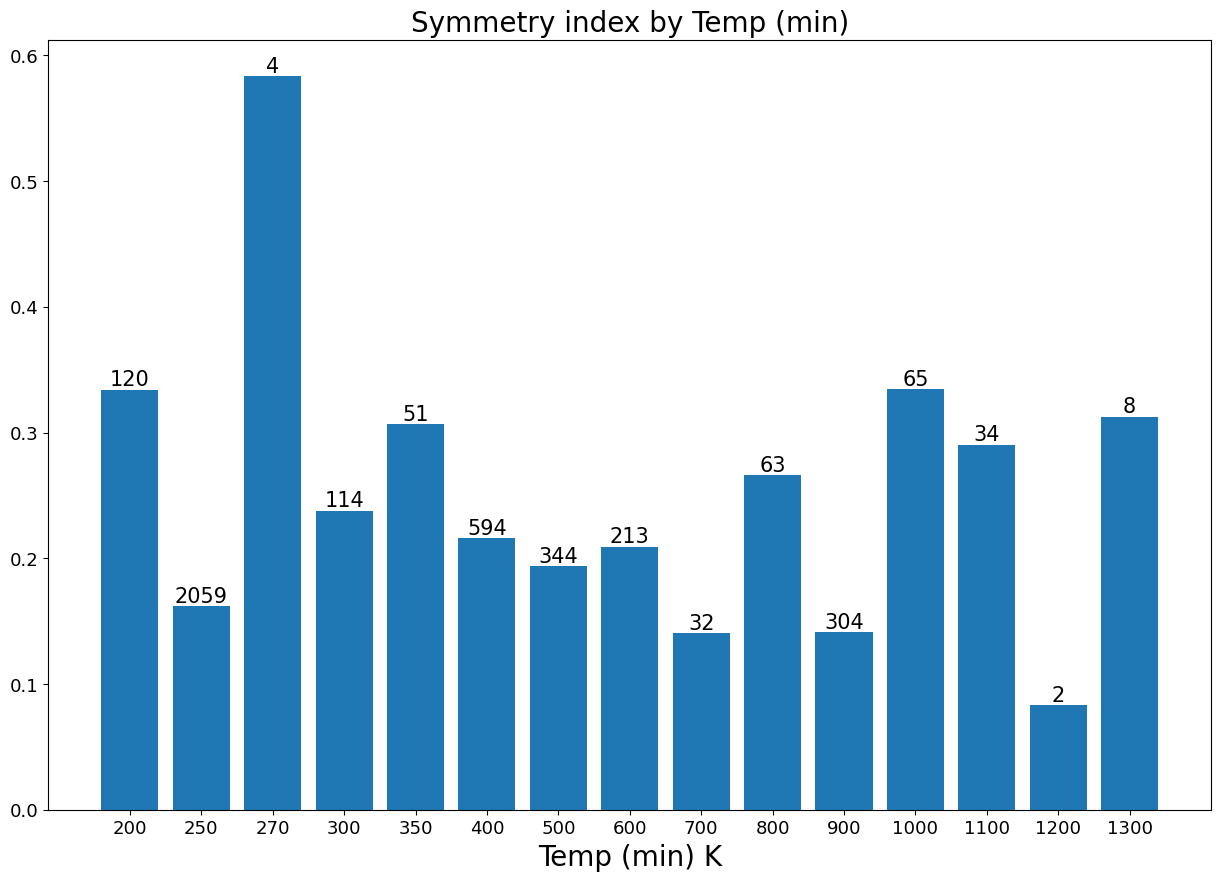

In [27]:
plot_crit(T_MIN, 'graph_tmin', nums=True)

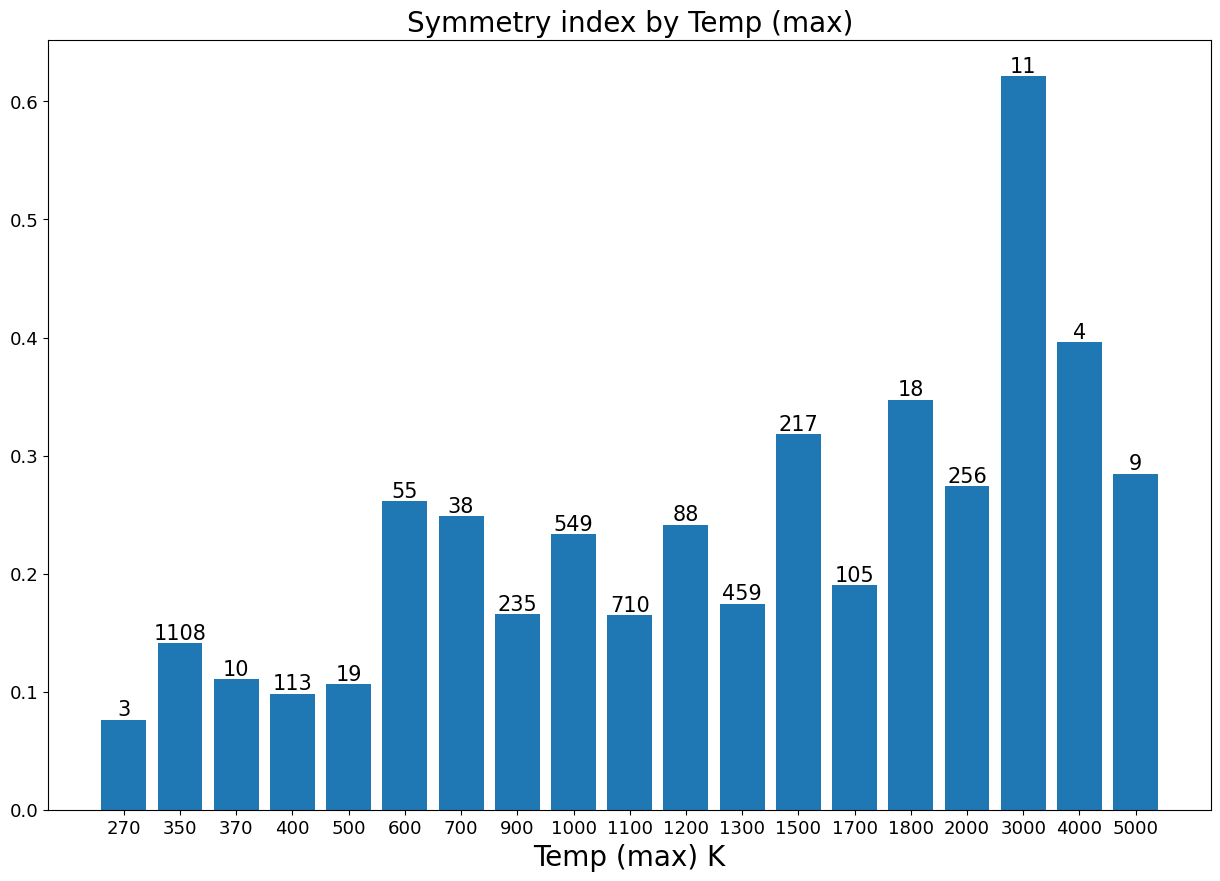

In [28]:
plot_crit(T_MAX, 'graph_tmax', nums=True)

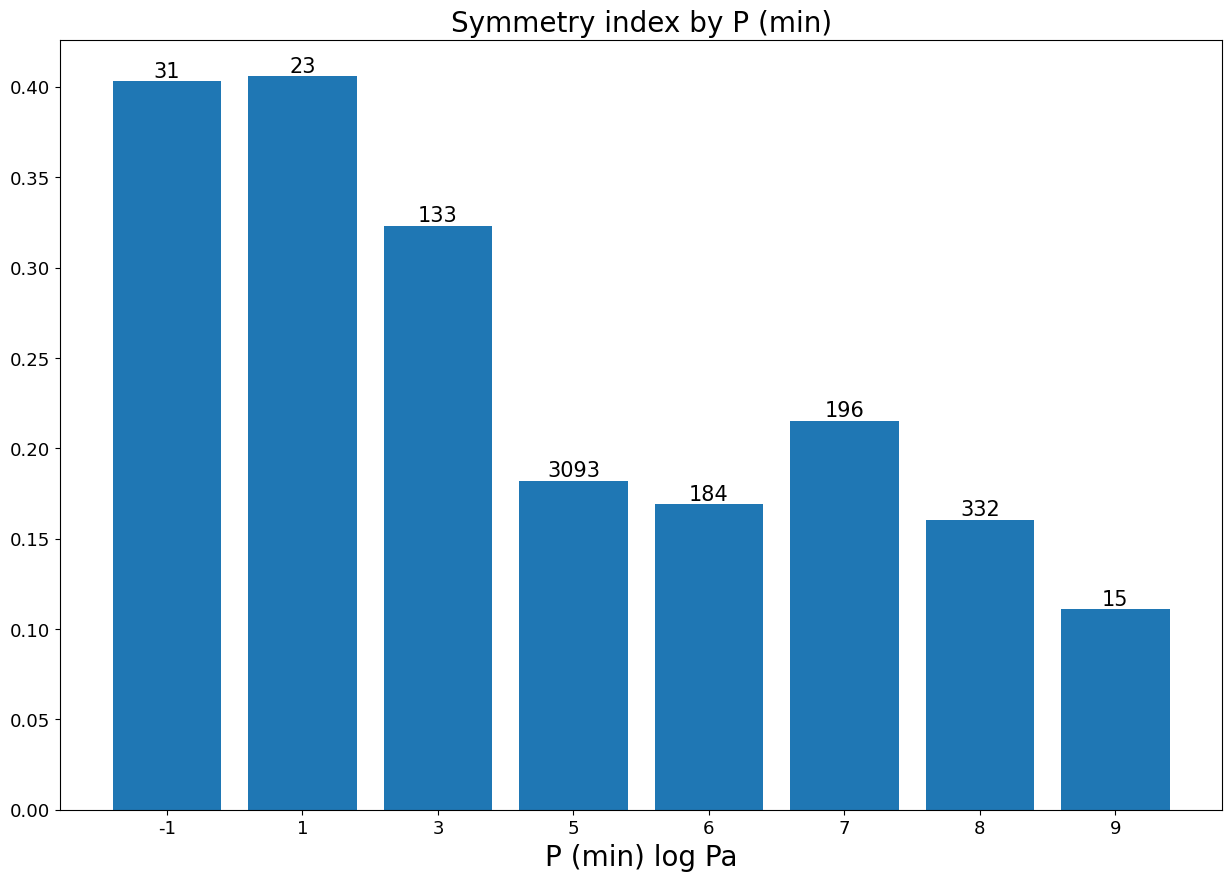

In [29]:
plot_crit(P_MIN, 'graph_pmin', nums=True)

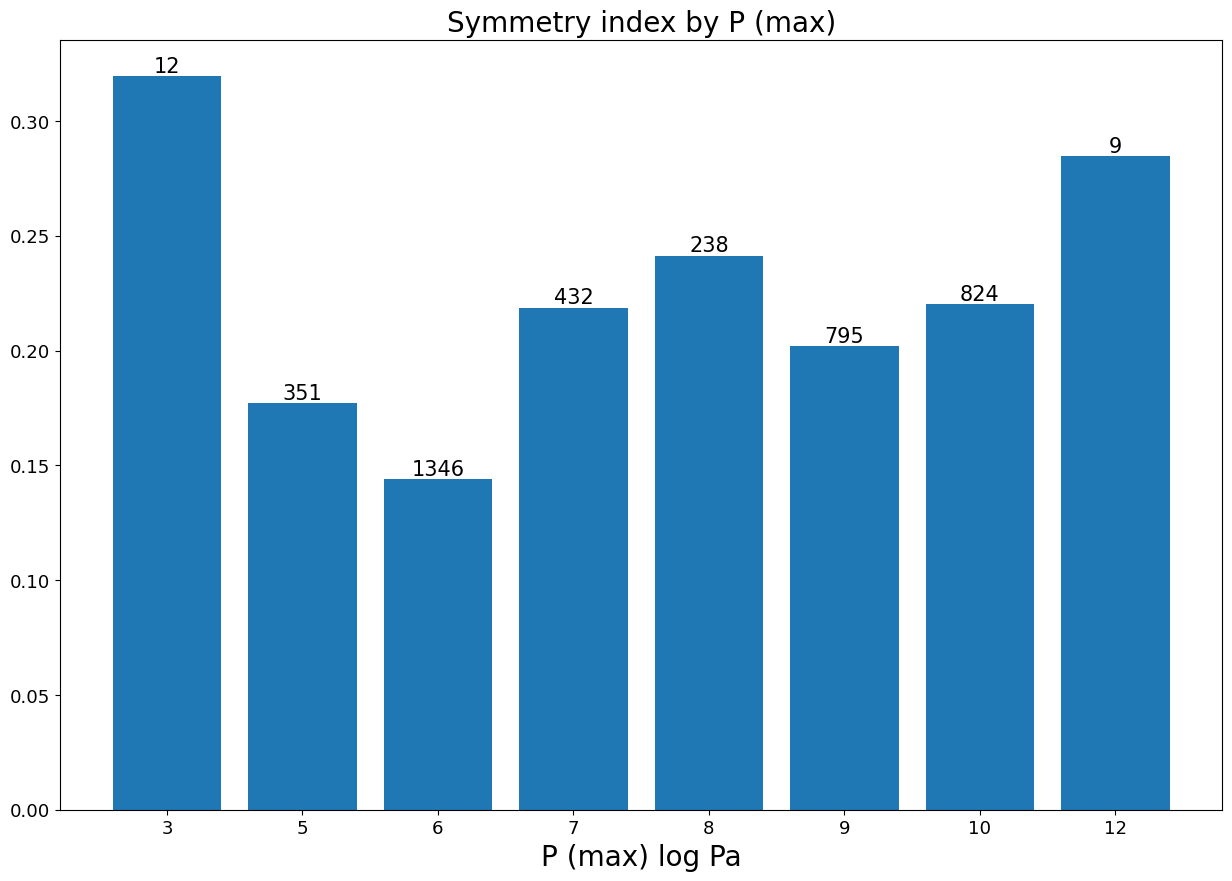

In [30]:
plot_crit(P_MAX, 'graph_pmax', nums=True)

In [31]:
def scatter_crit(CRIT, name, fit_q=False, start=None, end=None):
    if type(end) == int:
        end = -end
    
    plt.figure(figsize=(15, 10))
    ordering = list(crit_symmetry_indices[CRIT].keys())[start:end]
    syms = [ crit_symmetry_indices[CRIT][p] for p in ordering ]
    l = len(ordering)

    crit_name = " ".join(CRIT.split()[:2])
    if start is not None or end is not None:
        str_start = str(start) if start is not None else ''
        str_end = str(end) if end is not None else ''
        
        name += f'_exc_[{str_start}-{str_end}]'
    
    fit_lin = polyfit(ordering, syms, 1)
    poly_fit_lin = np.poly1d(fit_lin[::-1])
    
    y_avg = sum(syms)/len(syms)
    ss_res = sum([ (y-f)**2 for y, f in zip(syms, poly_fit_lin(ordering)) ])
    ss_tot = sum([ (y-y_avg)**2 for y in syms ])
    R2 = 1 - ss_res/ss_tot
    print(f'R^2 = {R2:.4f}')
    print(f'sqrt(R^2) = {np.sqrt(R2):.4f}')
    
    offset = max(ordering) / 50
    xs = np.linspace(min(ordering) - offset, max(ordering) + offset, 10000)
    plt.plot(xs, poly_fit_lin(xs))
    
    if fit_q:
        fit_quad = polyfit(ordering, syms, 2)
        plt.plot(xs, np.poly1d(fit_quad[::-1])(xs))
    
    plt.scatter(ordering, syms)
    
    plt.tick_params(axis='both', labelsize=FS_TICK)
    plt.title(f'Symmetry index by {crit_name}', fontsize=FS_TITLE)
    plt.xlabel(CRIT, fontsize=20)

    # [ print(f'{p}:\t {sym:.3f}') for p, sym in pgm_symmetry_indices.items() ]

    plt.savefig(f'results/{name}.png')

R^2 = 0.0448
sqrt(R^2) = 0.2116


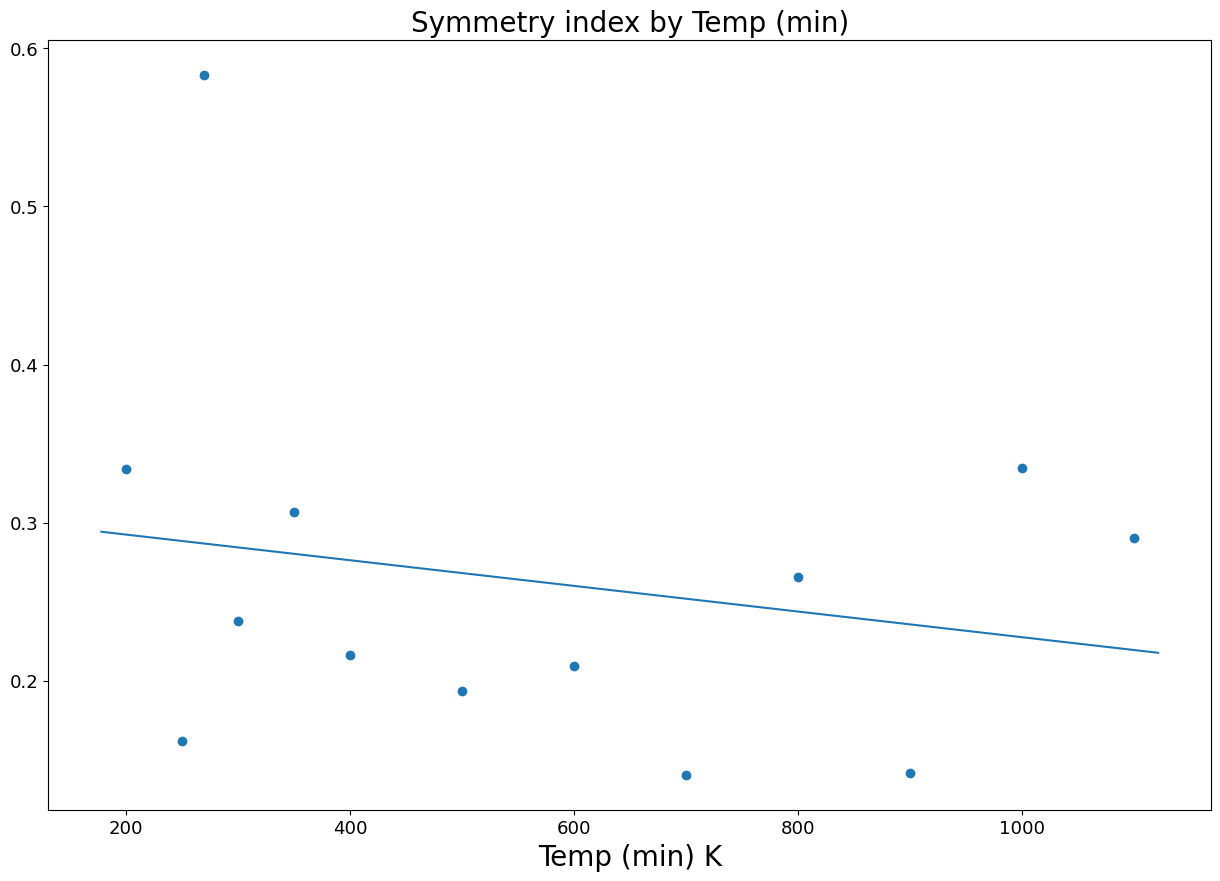

In [32]:
scatter_crit(T_MIN, 'graph_scatter_tmin', end=2)

R^2 = 0.4703
sqrt(R^2) = 0.6858


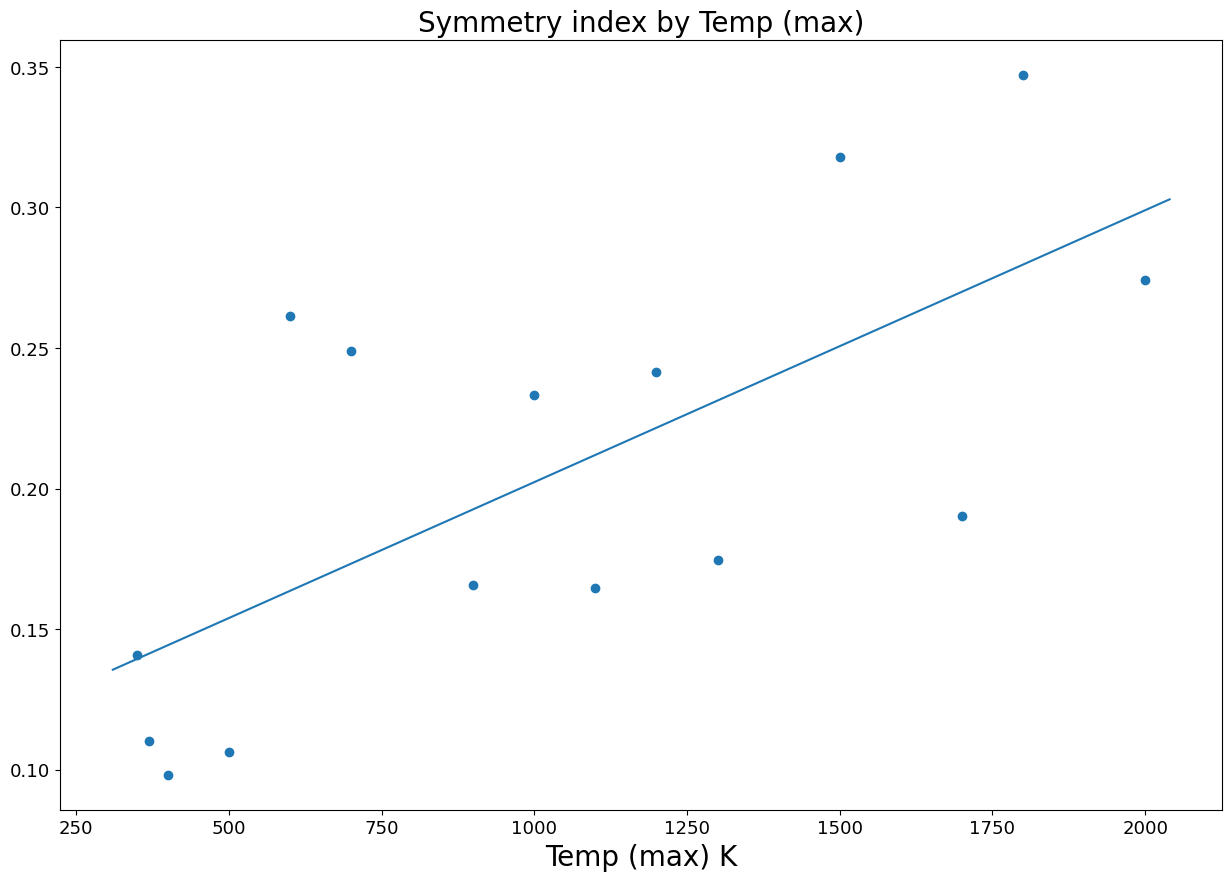

In [33]:
scatter_crit(T_MAX, 'graph_scatter_tmax', start=1, end=3)

R^2 = 0.8714
sqrt(R^2) = 0.9335


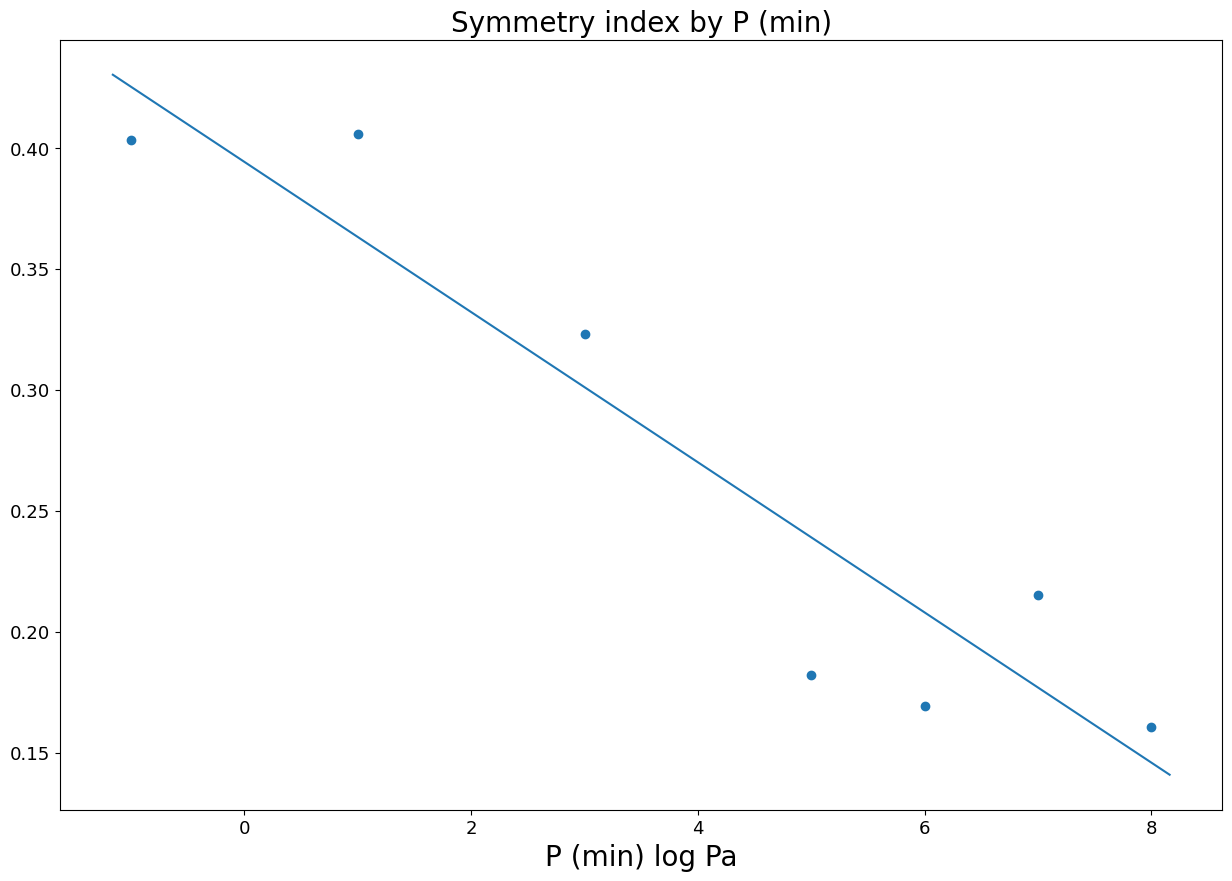

In [34]:
scatter_crit(P_MIN, 'graph_scatter_pmin', end=1)

R^2 = 0.3966
sqrt(R^2) = 0.6298


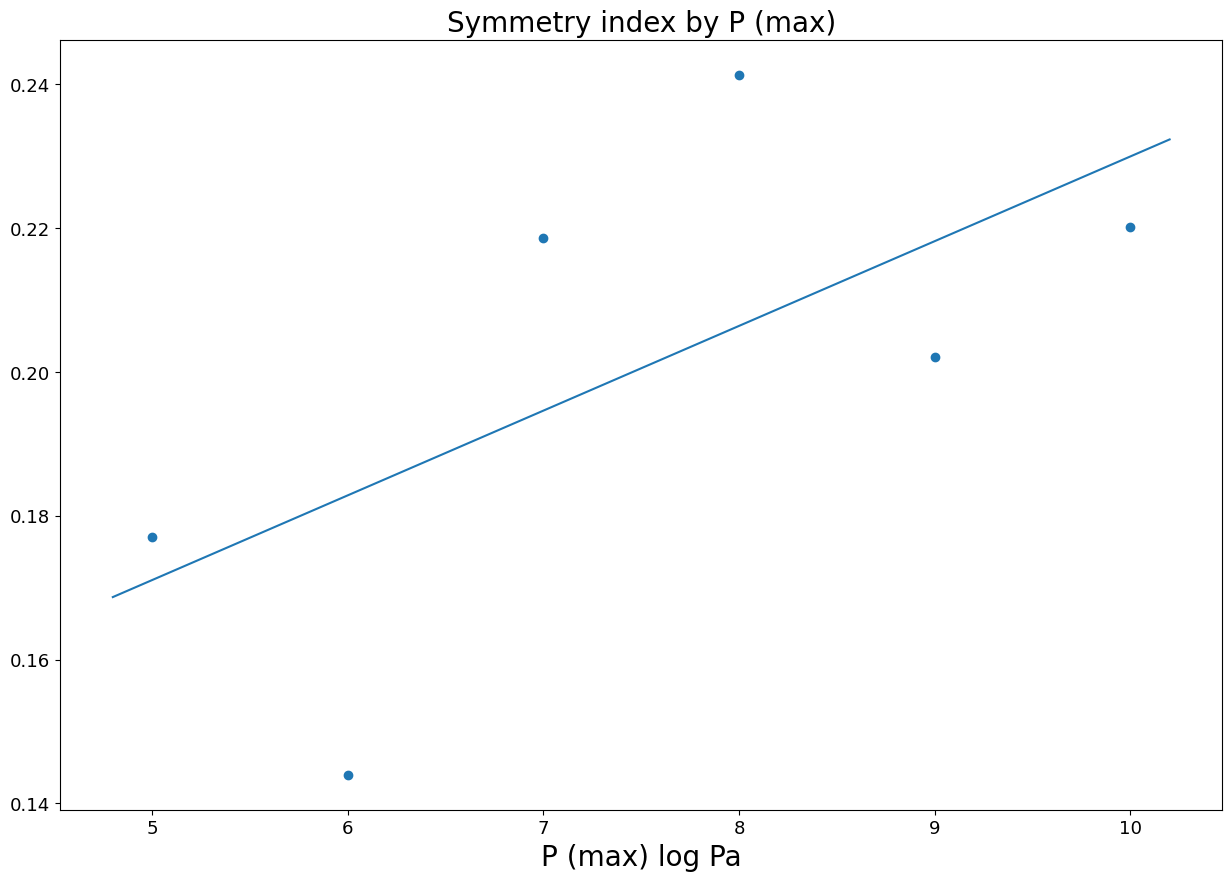

In [35]:
scatter_crit(P_MAX, 'graph_scatter_pmax', start=1, end=1)

R^2 = 0.6628
sqrt(R^2) = 0.8141


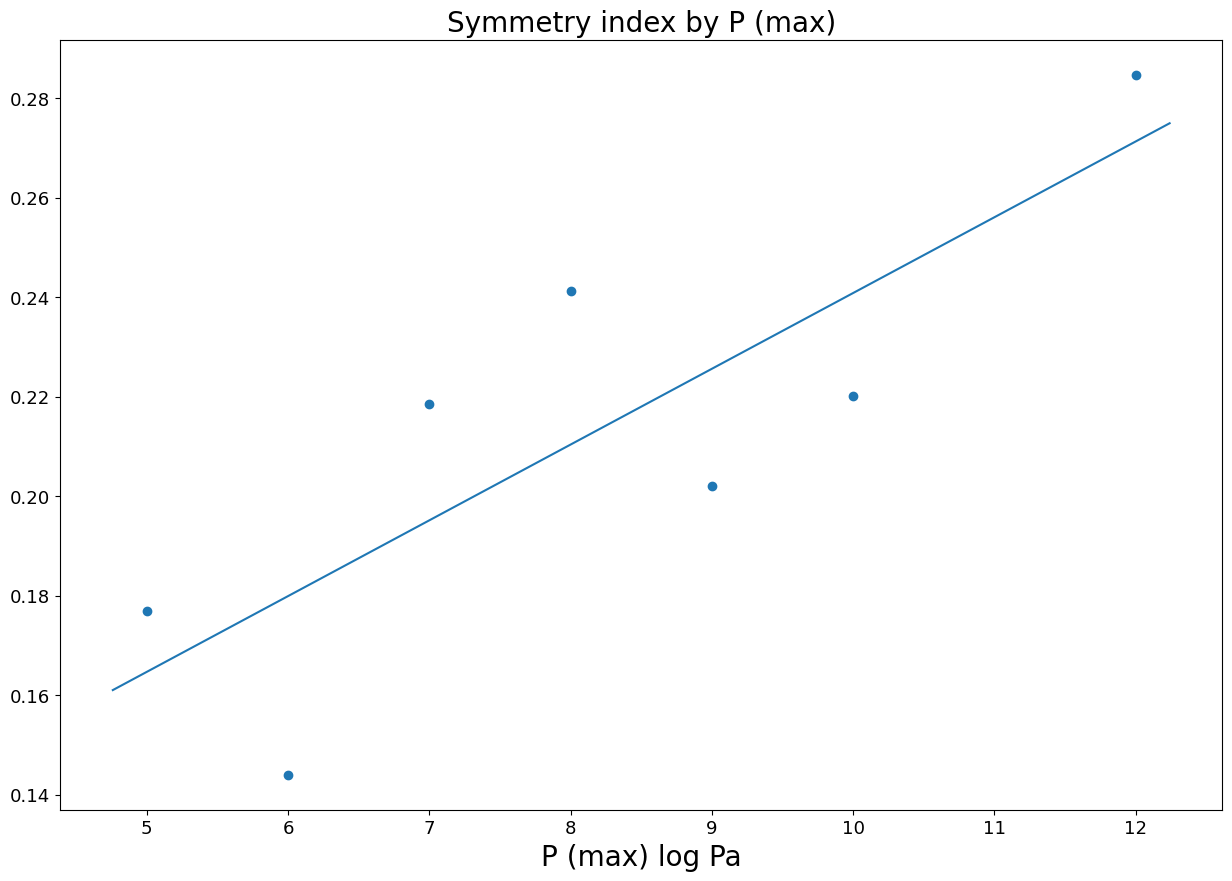

In [36]:
scatter_crit(P_MAX, 'graph_scatter_pmax', start=1, end=None)